## Семинар 5. Стационарность. Белый шум. MA-процесс.

##### Стационарность

Для начала кратко повторим, что такое стационарность. $y_t$ называется слабо стационарным процессом, если:

$$E[y_t] = \mu$$

$$cov(y_t, y_{t-k}) = \gamma_k$$

Мы уже мельком говорили, что стационарные процессы нам интересны по причине простоты в их прогнозировании. И действительно, чем меньше характеристик процесса изменяется со временем, тем проще построить прогноз. А ещё мы задёшево можем сводить нестационарные ряды к стационарным (ну или почти стационарными). 

На лекции вам уже приводили теорему Вольда и рассказали, что можно разложить слабо стационарный процесс на прогнозируемую часть и MA($\infty$)-процесс. Однако для того, чтобы определить MA-процесс, нужно поговорить о вспомогательном объекте: процессе белого шума (White Noise)

##### Процесс белого шума

Процес белого шума сам по себе является частным случаем стационарного ряда. 

$$E[y_t] = 0$$

$$Var[y_t] = \sigma^2$$

$$cov(y_t, y_{t-k}) = 0 \ \forall \ k \neq 0$$


Попробуем сгенерировать самый простой случай белого шума -- последовательность iid N(0,1) случайных величин.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np

from scipy.stats import norm, chi2 
from sktime.utils.plotting import plot_correlations


plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)


<Axes: title={'center': 'White Noise process'}, xlabel='Time'>

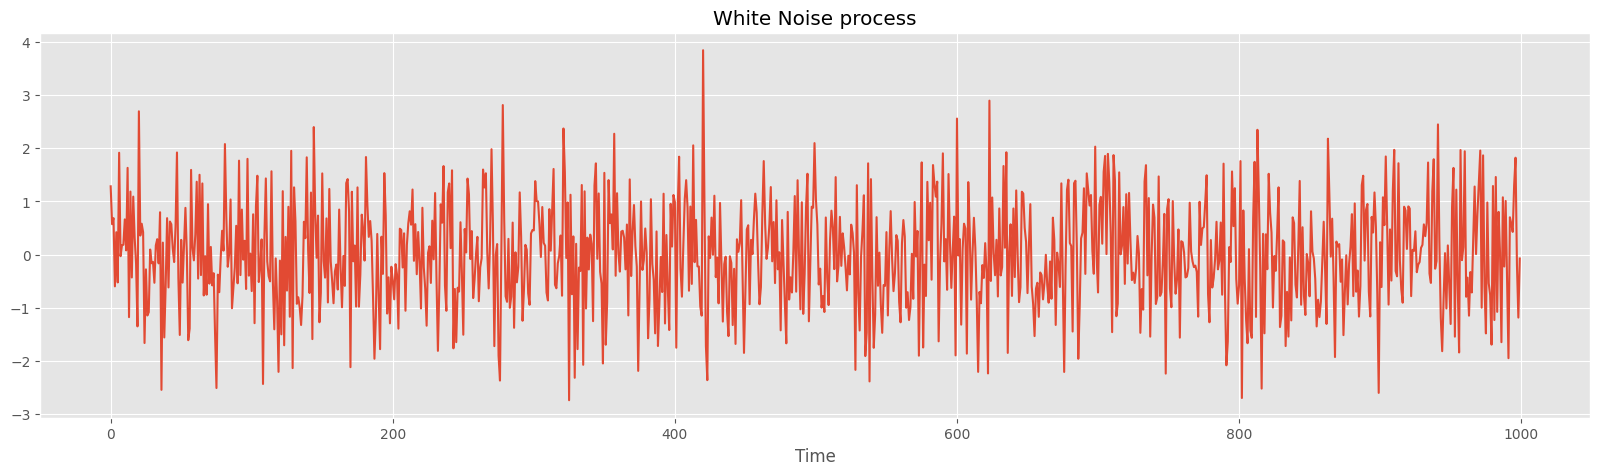

In [2]:
n_obs = 1000
sample = pd.Series(np.random.normal(size=n_obs))

plt.title('White Noise process')
plt.xlabel('Time')
sample.plot()

Попробуем проверить, действительно ли выполняются на таком временном ряде условия белого шума. Начнём с оценки математического ожидания. Построим самую простую оценку -- среднее.

In [3]:
mu_hat = np.mean(sample)
mu_hat

-0.005801654390465222

In [4]:
# p-value гипотезы о равенстве среднего нулю
2 * norm.cdf(-1 * np.sign(mu_hat) *mu_hat * np.sqrt(n_obs) / np.std(sample)) 


0.8546882142069724

Проверим дисперсию на разных участках.

In [5]:
# На левом
np.std(sample.head(300))

0.9819558406579423

In [6]:
# На правом
np.std(sample.tail(300))

1.0122526830564902

Также можно как и раньше протестировать автокорреляции с помощь Portmanteau тестов.

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

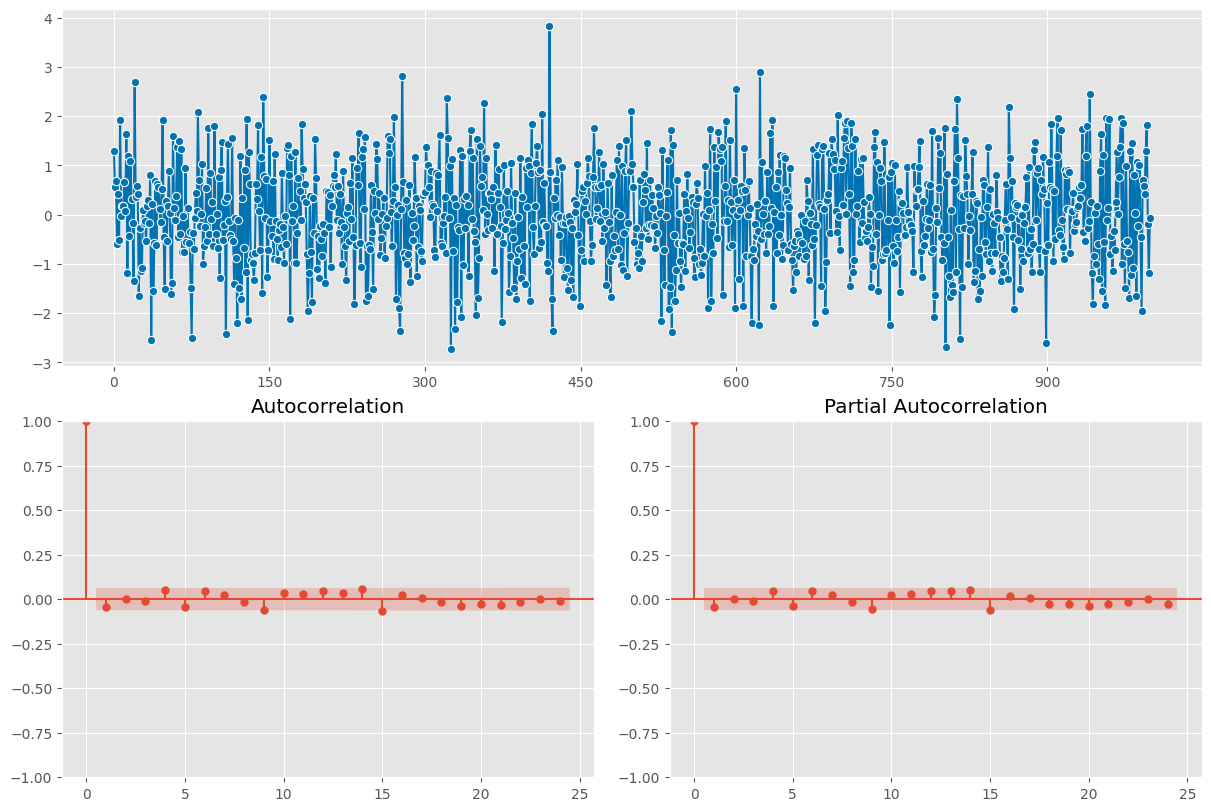

In [7]:
plot_correlations(sample)

In [8]:
from statsmodels.stats.diagnostic import acorr_ljungbox

acorr_ljungbox(sample, lags=20, boxpierce=True)

lb_stat  lb_pvalue    bp_stat  bp_pvalue
1    1.763198   0.184226   1.757919   0.184884
2    1.763245   0.414110   1.757966   0.415205
3    1.839758   0.606321   1.834097   0.607543
4    4.235757   0.375039   4.215749   0.377594
5    6.106642   0.295980   6.073563   0.299127
6    8.209644   0.223143   8.159775   0.226630
7    8.630569   0.280279   8.576919   0.284475
8    8.822155   0.357520   8.766593   0.362367
9   12.531404   0.184981  12.435122   0.189875
10  13.528937   0.195582  13.420708   0.201091
11  14.213090   0.221426  14.095986   0.227728
12  16.173266   0.183428  16.028773   0.189922
13  17.512992   0.176901  17.348444   0.183861
14  20.563563   0.113351  20.350304   0.119478
15  25.139943   0.048095  24.849040   0.052008
16  25.715073   0.058172  25.413839   0.062854
17  25.789218   0.078387  25.486578   0.084336
18  26.045352   0.098725  25.737599   0.105911
19  27.310948   0.097616  26.976671   0.105198
20  27.921672   0.111267  27.573986   0.119874

Мы тестировали остатки с помощью теста Ljung-Box, но оказывается, что стандартные тесты не очень для этого подходят. Об этом есть даже некоторый небольшой [тред](https://stats.stackexchange.com/questions/148004/testing-for-autocorrelation-ljung-box-versus-breusch-godfrey), можете почитать, если интересно. Несколько лучше подходит для этих целей тест Бройша-Годфри. Он предполагает, что оценена линейная регрессионная модель и позволяет протестировать остатки такой модели на наличие автокорреляций. Правда, обычно на практике это игнорируется и смотрят либо визуально на остатки, либо с помощью стандартных тестов.

In [9]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey

##### MA-процесс

Теперь посмотрим повнимательнее на MA-процесс. Как мы уже знаем, для описания стационарного ряда нам необходима модель $MA(\infty)$. Однако, по понятным причинам, оценить её не представляется возможным. Да и не встречается такой острой в этом необходимость. Попробуем поговорить про $MA(k)$-модель. Она выглядит следующим образом:

$$y_t = \mu + \epsilon_t + \alpha_1 \epsilon_{t-1} + \cdots + \alpha_k \epsilon_{t-k}$$

В классических учебниках часто записывается следующая форма:

$$y_t = \mu + \epsilon_t - \alpha_1 \epsilon_{t-1} - \cdots - \alpha_k \epsilon_{t-k}$$

Но понятное дело, что эти формы суть есть одно и то же с точность до знака $\alpha_i$. Мы будем пользоваться первой формулой. В пакетах она более распространена. Попробуем посимулировать и взглянуть на различные MA-процессы.

In [10]:
from statsmodels.api import tsa

Начнём с процесса белого шума, или MA(0):

$$y_t = \mu + \epsilon_t, \ \epsilon_t \sim iid N(0, 1)$$

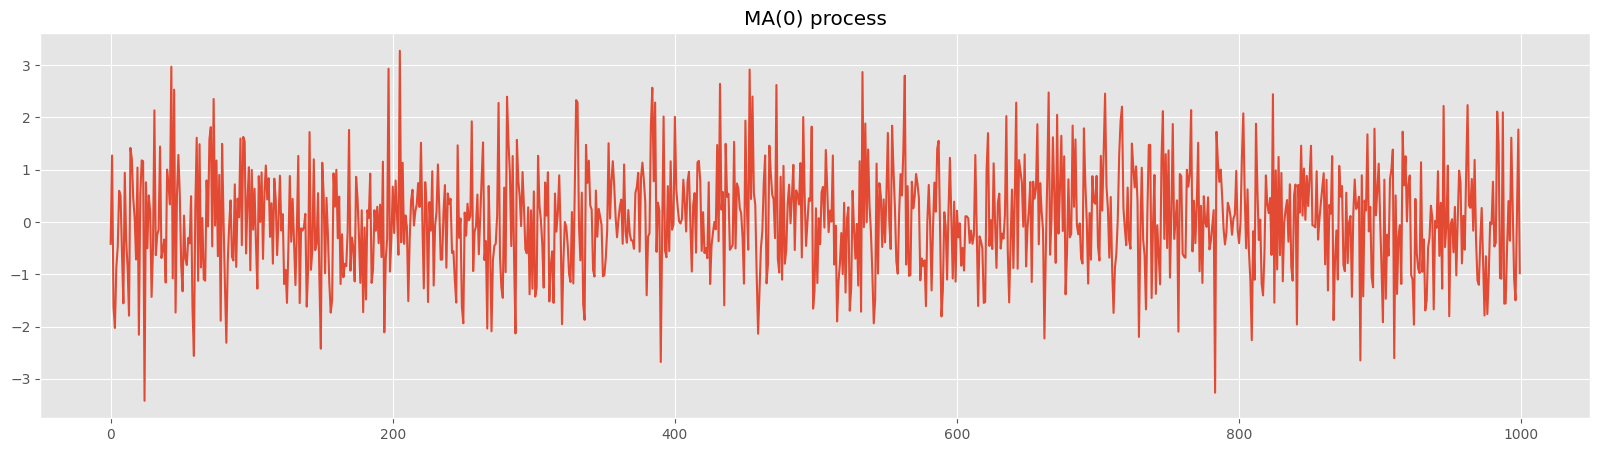

In [11]:
wn_process = tsa.ArmaProcess()
sample = pd.Series(wn_process.generate_sample(nsample=n_obs, burnin = 1000))
sample.plot()
plt.title('MA(0) process');

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot: >,
        <AxesSubplot: title={'center': 'Autocorrelation'}>,
        <AxesSubplot: title={'center': 'Partial Autocorrelation'}>],
       dtype=object))

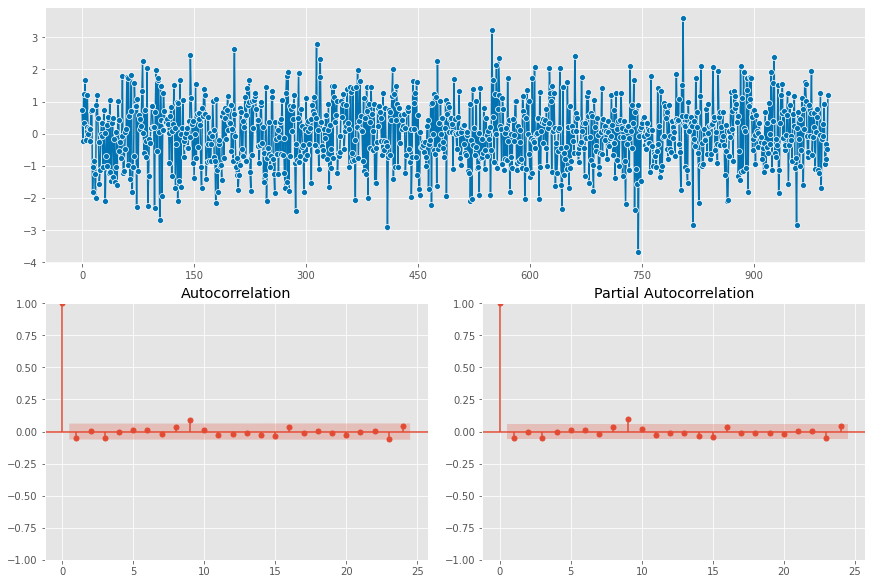

In [50]:
plot_correlations(sample)

Теперь MA(1):

$$y_t = \mu + \epsilon_t + 0.9 \epsilon_{t-1}, \ \epsilon_t \sim iid N(0, 1)$$

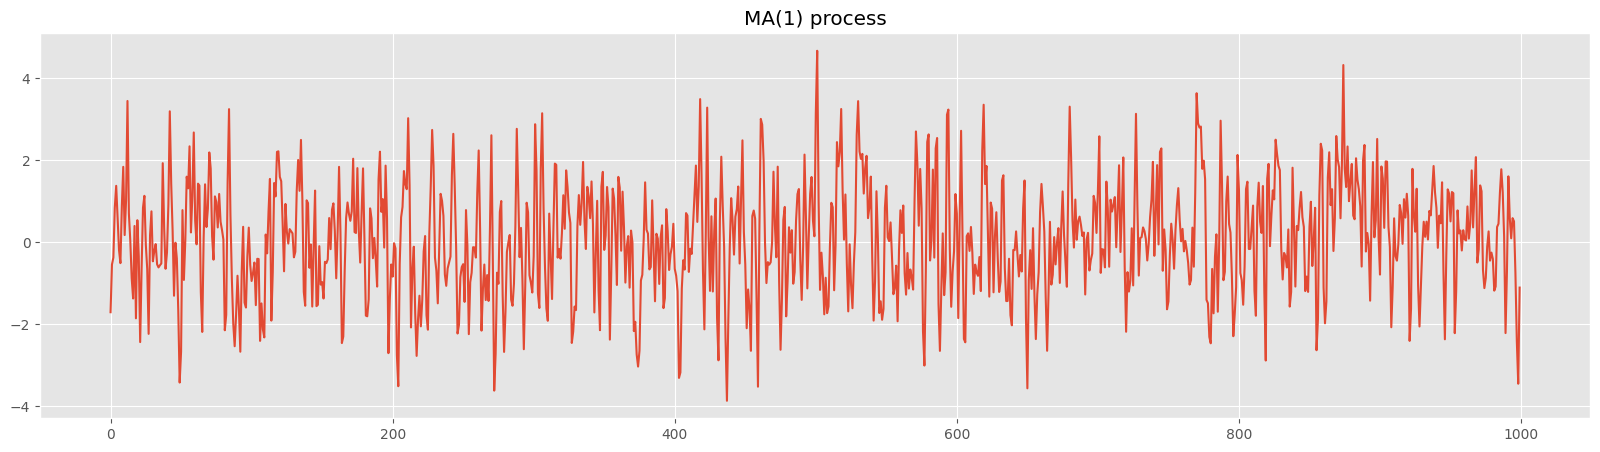

In [12]:
ma_process = tsa.ArmaProcess(ma=[1, 0.9])
sample = pd.Series(ma_process.generate_sample(nsample=n_obs, burnin = 10000))
sample.plot()
plt.title('MA(1) process');

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

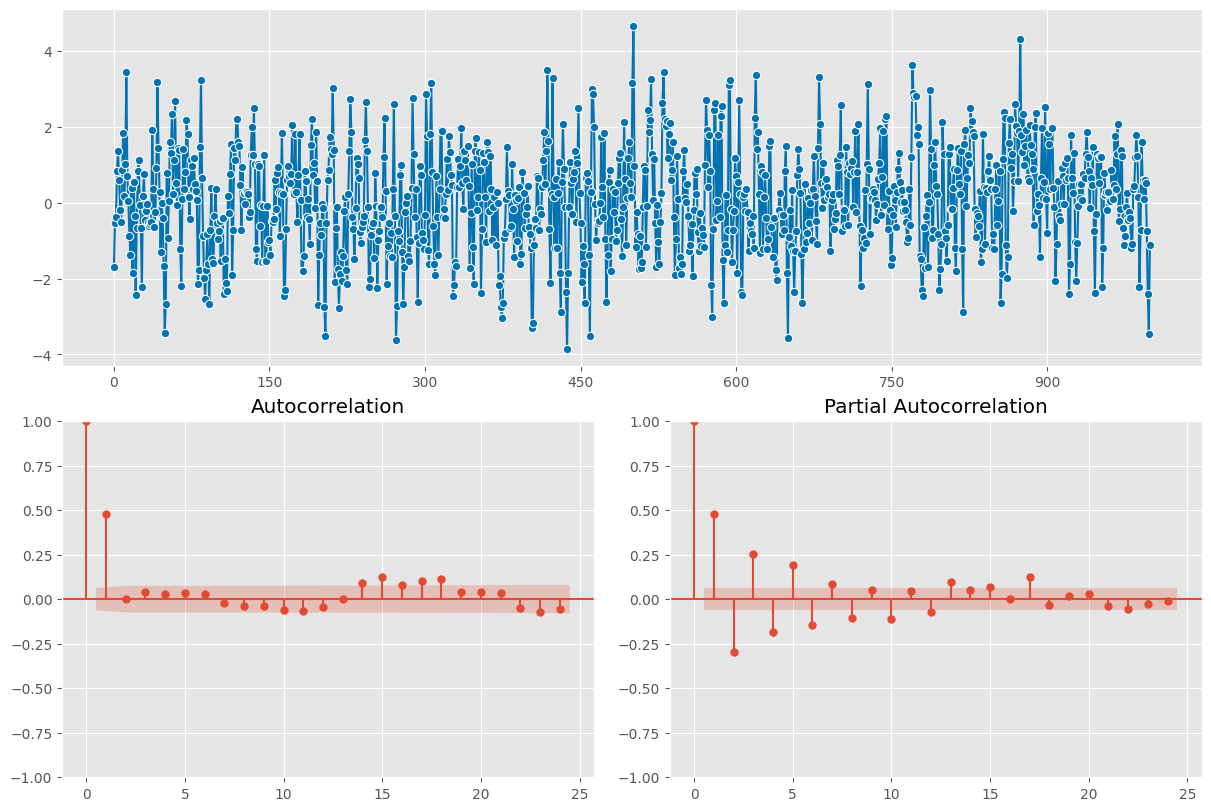

In [13]:
plot_correlations(sample)


MA(5):

$$y_t = \mu + \epsilon_t + 0.9 \epsilon_{t-1} + 0.8 \epsilon_{t-2} + 0.5 \epsilon_{t-3} + 0.6 \epsilon_{t-4} + 0.2 \epsilon_{t-5}, \ \epsilon_t \sim iid N(0, 1)$$

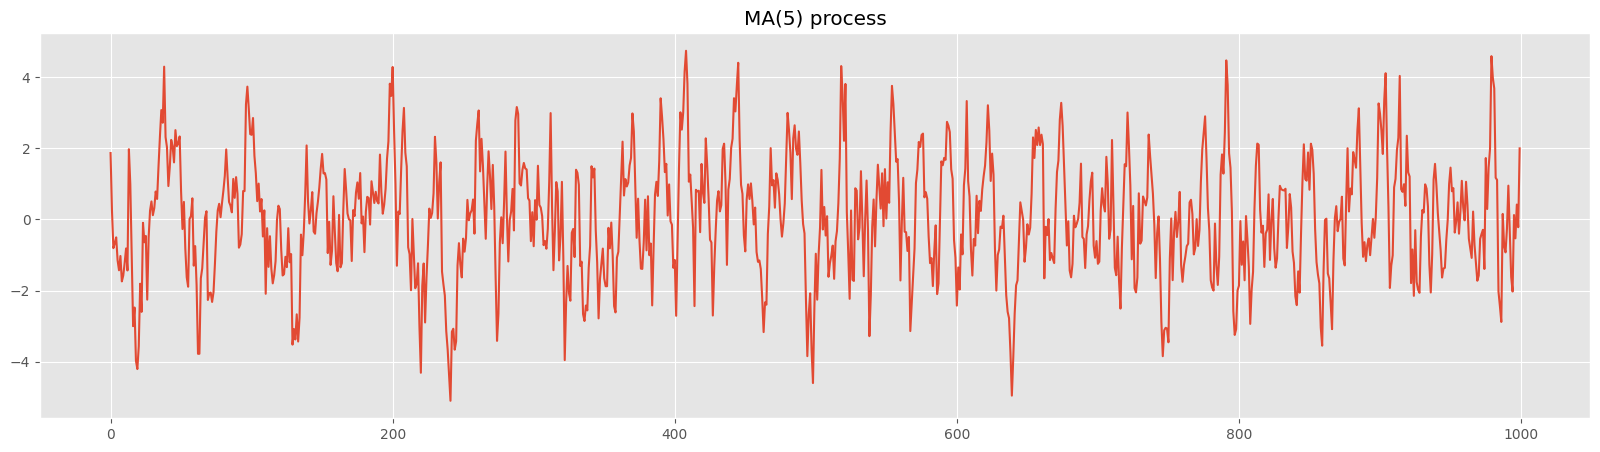

In [14]:
ma_process = tsa.ArmaProcess(ma=[1, 0.9, 0.8, 0.5, 0.6, 0.2])
sample = pd.Series(ma_process.generate_sample(nsample=n_obs, burnin = 1000))
sample.plot()
plt.title('MA(5) process');

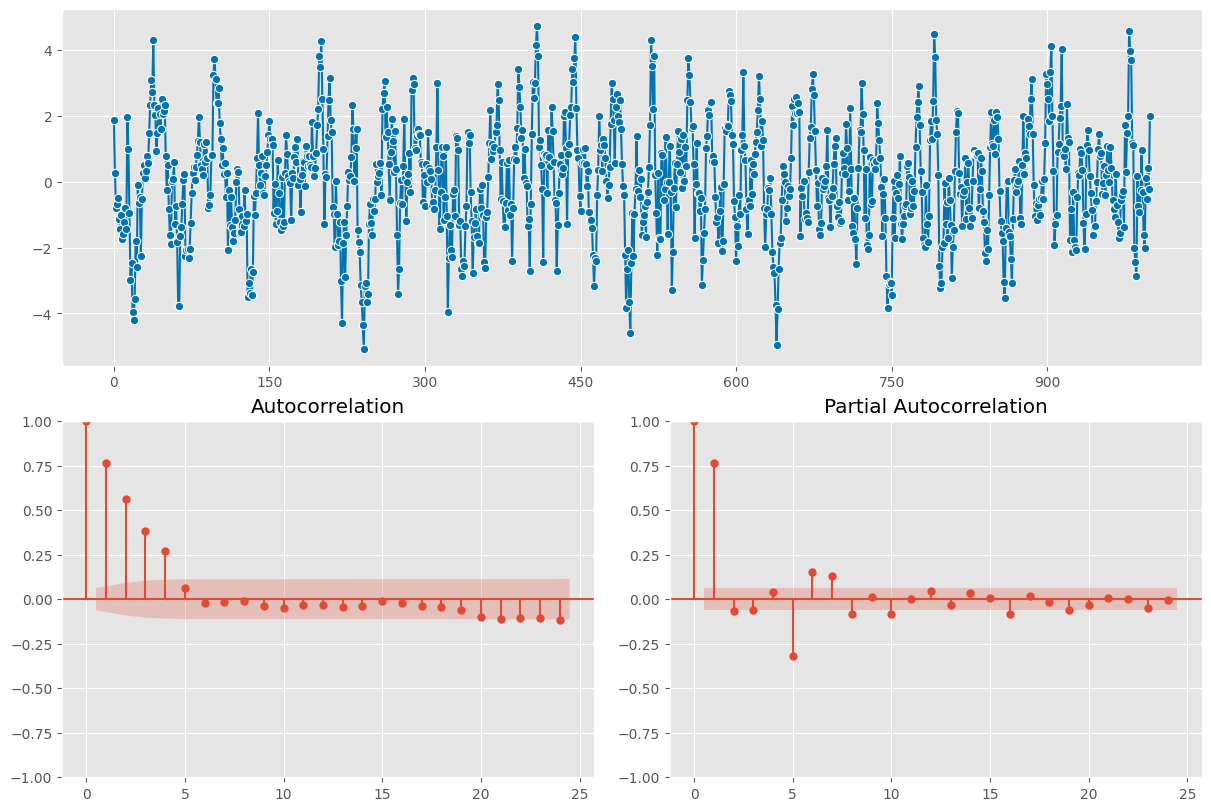

In [15]:
plot_correlations(sample);

Давайте немного поработаем с последним сэмплом. Так как это процесс пятого порядка, у него довольно сложная струткура. Посмотрим, что будет, если оценить модель проще, аналогичную или сложнее чем исходный ряд. Для начала предположим, что мы взяли модель правильного порядка, посмотрев на коррелогаммы. Заодно определим, как вычисляются прогнозы MA(q)-модели.

Выпишем для начала прогноз на один шаг
$$\hat{y}_{T+1} = E[y_{T+1} | T] = E[\mu + \epsilon_{T+1} + \alpha_1 \epsilon_{T} + \ldots + \alpha_k \epsilon_{T-k+1} | T] =$$

$$= \mu + 0 + \alpha_1 \epsilon_{T} + \ldots + \alpha_k \epsilon_{T-k+1}$$

Аналогично на два шага

$$\hat{y}_{T+2} = E[y_{T+2} | T] = E[\mu + \epsilon_{T+2} + \alpha_1 \epsilon_{T+1} + \ldots + \alpha_k \epsilon_{T-k+2} | T] =$$

$$= \mu + 0 + \alpha_1 \cdot 0 + \ldots + \alpha_k \epsilon_{T-k+1}$$

Нетрудно заметить, что после шага k мы сойдёмся к $\mu$

Интервальный прогноз вычисляется аналогично.


In [16]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

coverage = 0.95
test_size = 50
train, test = temporal_train_test_split(sample, test_size = test_size)

<Axes: >

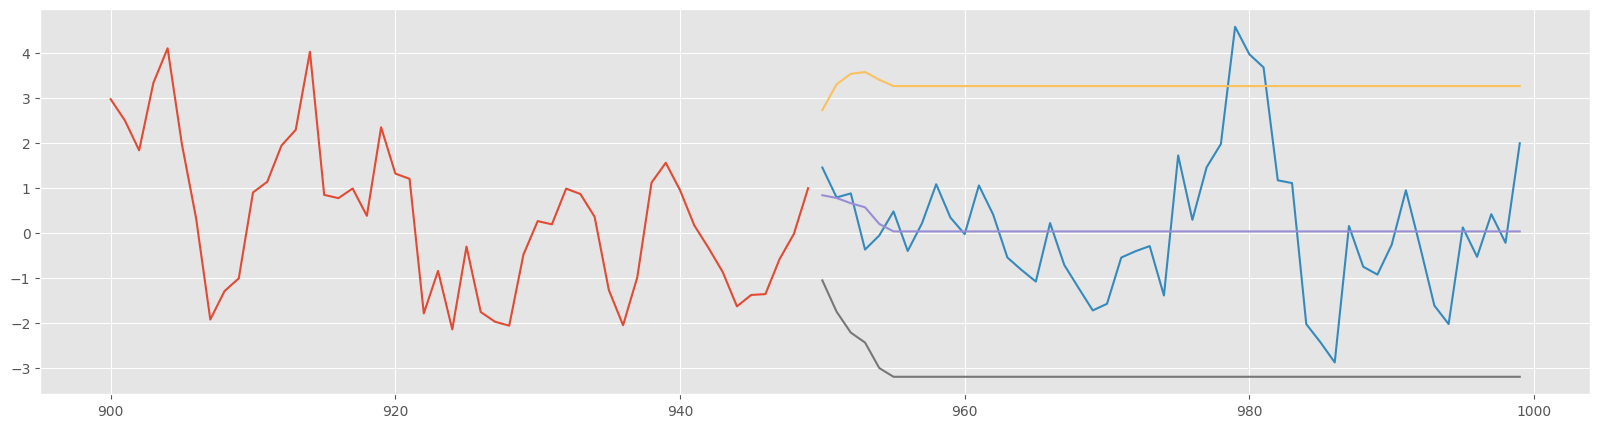

In [23]:
forecaster = ARIMA(order = (0,0,5))

forecaster.fit(train)

forecast = forecaster.predict(list(range(1, test_size+1)))
variance = forecaster.predict_interval(list(range(1, test_size+1)), coverage = coverage)

train.tail(50).plot()
test.plot()
forecast.plot()
variance[0][coverage]['lower'].plot()
variance[0][coverage]['upper'].plot()

Посмотрим на остатки одношаговых прогнозов на трейне

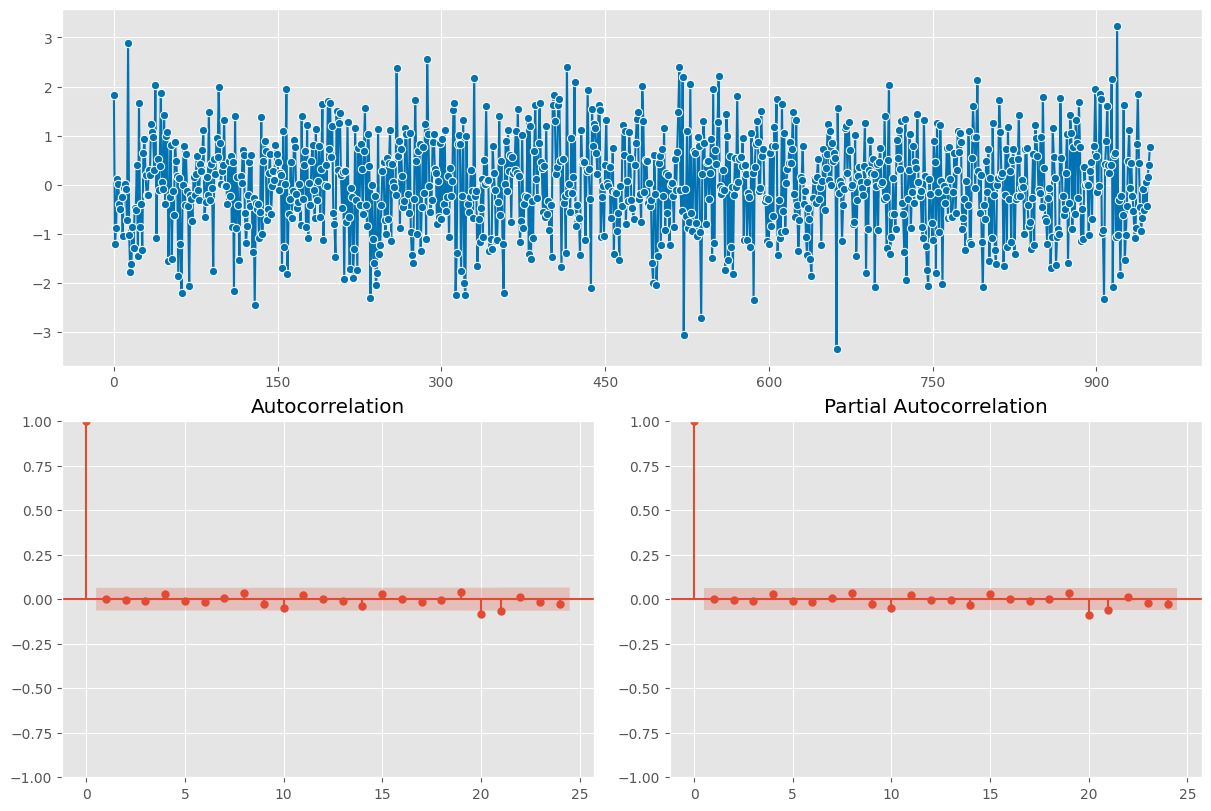

In [24]:
resid = forecaster.predict_residuals()
plot_correlations(resid);

Как видим, значимых автокорреляций нет. Значит, мы построили хорошую линейную модель и аппроксимировали всю линейную динамику. В дополнение проведём тесты.

In [25]:
acorr_ljungbox(resid)

lb_stat  lb_pvalue
1   0.000147   0.990320
2   0.032482   0.983890
3   0.100316   0.991799
4   0.799337   0.938537
5   0.879501   0.971688
6   1.114344   0.980904
7   1.136576   0.992315
8   2.366683   0.967658
9   2.948507   0.966301
10  5.220284   0.875985

Для некоторого осмысленного количества лагов гипотеза об отсутствии автокорреляций не отвергается. Теперь оценим более слабую модель.

<Axes: >

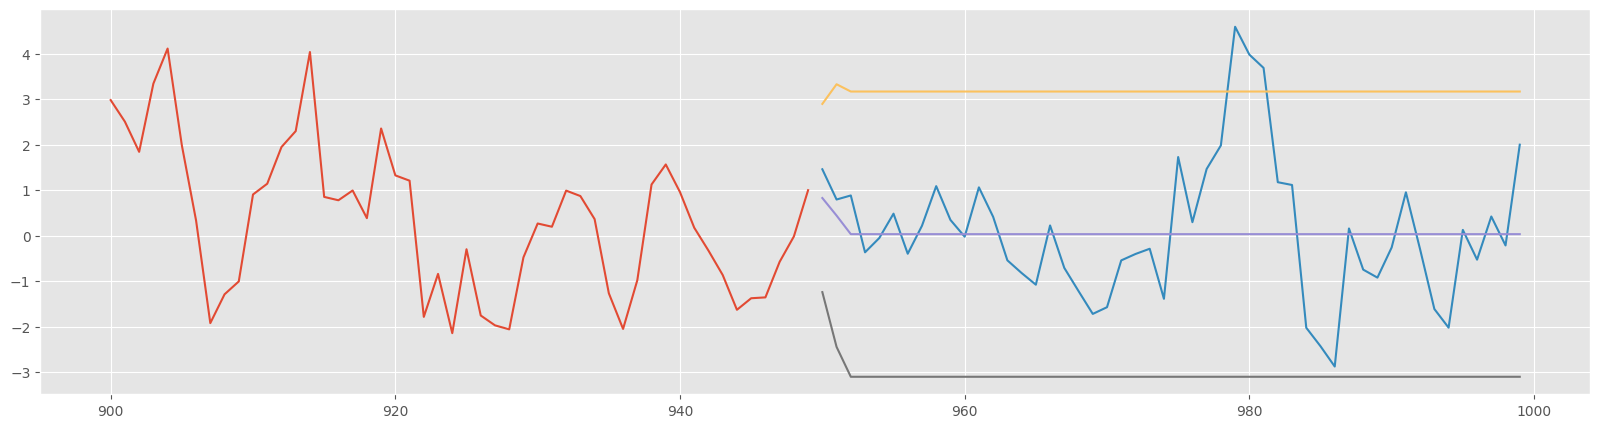

In [27]:
forecaster = ARIMA(order = (0,0,2))

forecaster.fit(train)

forecast = forecaster.predict(list(range(1, test_size+1)))
variance = forecaster.predict_interval(list(range(1, test_size+1)), coverage = coverage)

train.tail(50).plot()
test.plot()
forecast.plot()
variance[0][coverage]['lower'].plot()
variance[0][coverage]['upper'].plot()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

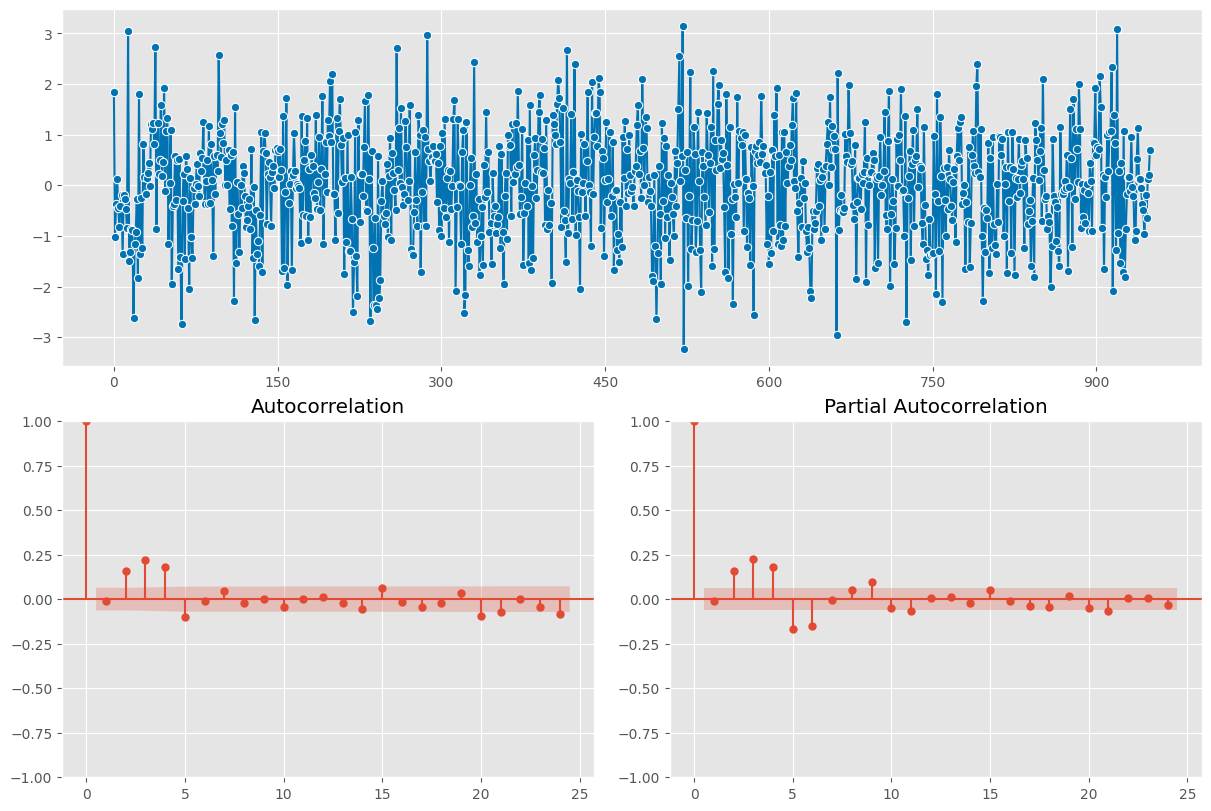

In [28]:
resid = forecaster.predict_residuals()
plot_correlations(resid)

In [29]:
acorr_ljungbox(resid)

lb_stat     lb_pvalue
1     0.143002  7.053150e-01
2    24.229499  5.478115e-06
3    69.285635  6.070369e-15
4   100.139055  9.188450e-21
5   110.061884  3.975785e-22
6   110.170454  1.877565e-21
7   111.985022  3.556164e-21
8   112.326598  1.265298e-20
9   112.326630  4.936739e-20
10  114.249904  7.395650e-20

Как видим, гипотеза отвергается для любых разумных лагов. Теперь оценим более сложную модель.

<Axes: >

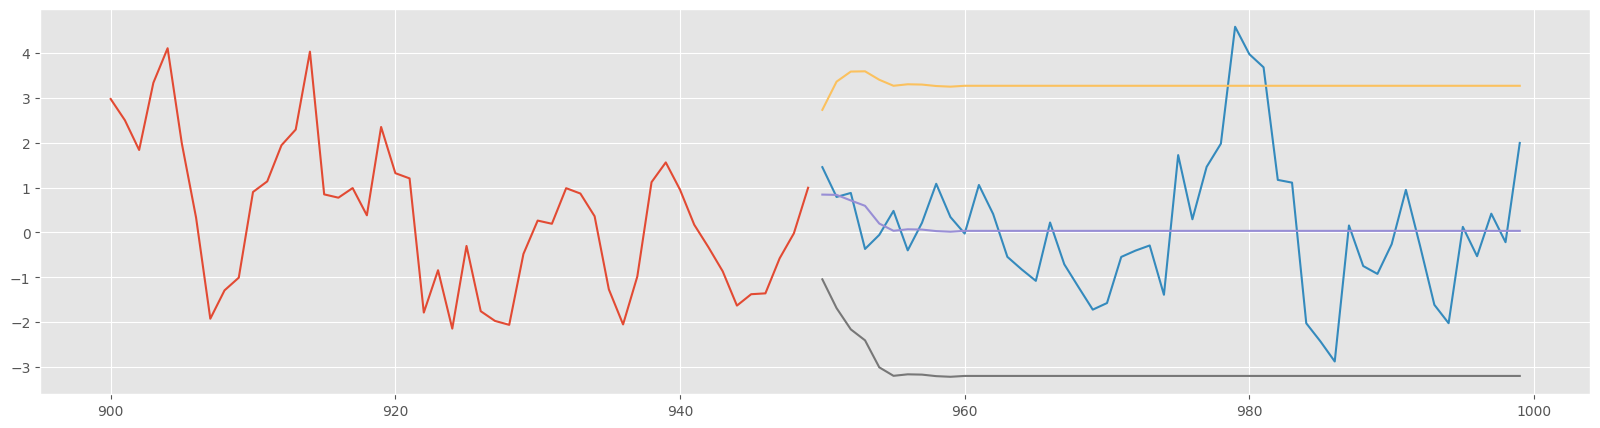

In [33]:
forecaster = ARIMA(order = (0,0,10))

forecaster.fit(train)

forecast = forecaster.predict(list(range(1, test_size+1)))
variance = forecaster.predict_interval(list(range(1, test_size+1)), coverage = coverage)

train.tail(50).plot()
test.plot()
forecast.plot()
variance[0][coverage]['lower'].plot()
variance[0][coverage]['upper'].plot()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

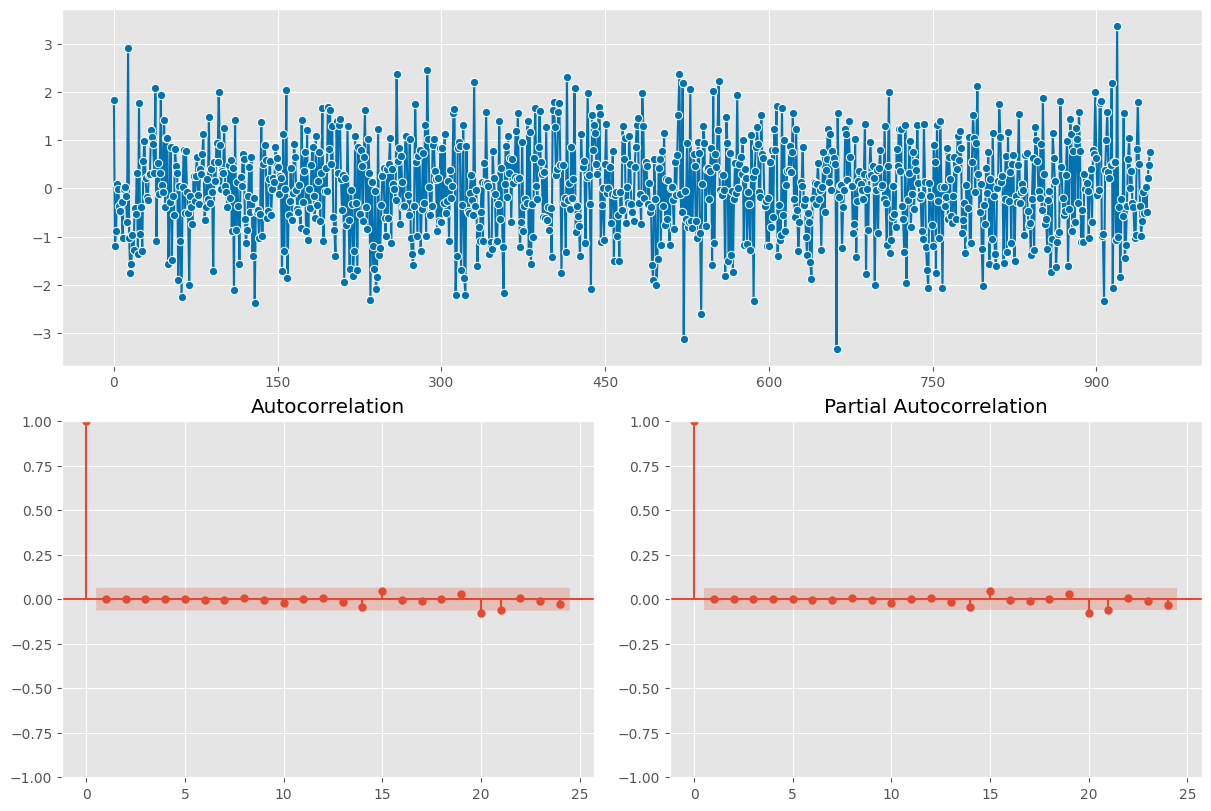

In [31]:
resid = forecaster.predict_residuals()
plot_correlations(resid)

In [34]:
acorr_ljungbox(resid, lags=20)

lb_stat  lb_pvalue
1    0.001095   0.973602
2    0.002481   0.998760
3    0.002792   0.999961
4    0.013280   0.999978
5    0.013346   0.999999
6    0.048865   0.999998
7    0.091267   0.999998
8    0.142346   0.999999
9    0.153671   1.000000
10   0.570394   0.999988
11   0.570395   0.999997
12   0.629705   0.999999
13   0.854895   0.999999
14   2.681684   0.999516
15   4.646688   0.994719
16   4.655564   0.997218
17   4.797051   0.998288
18   4.798461   0.999140
19   5.529833   0.998827
20  10.875566   0.949386

In [35]:
import matplotlib.pyplot as plt
import pandas as pd

from sktime.utils.plotting import plot_correlations
from statsmodels.api import tsa
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error



plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (20,5)

### AR(p)-процесс

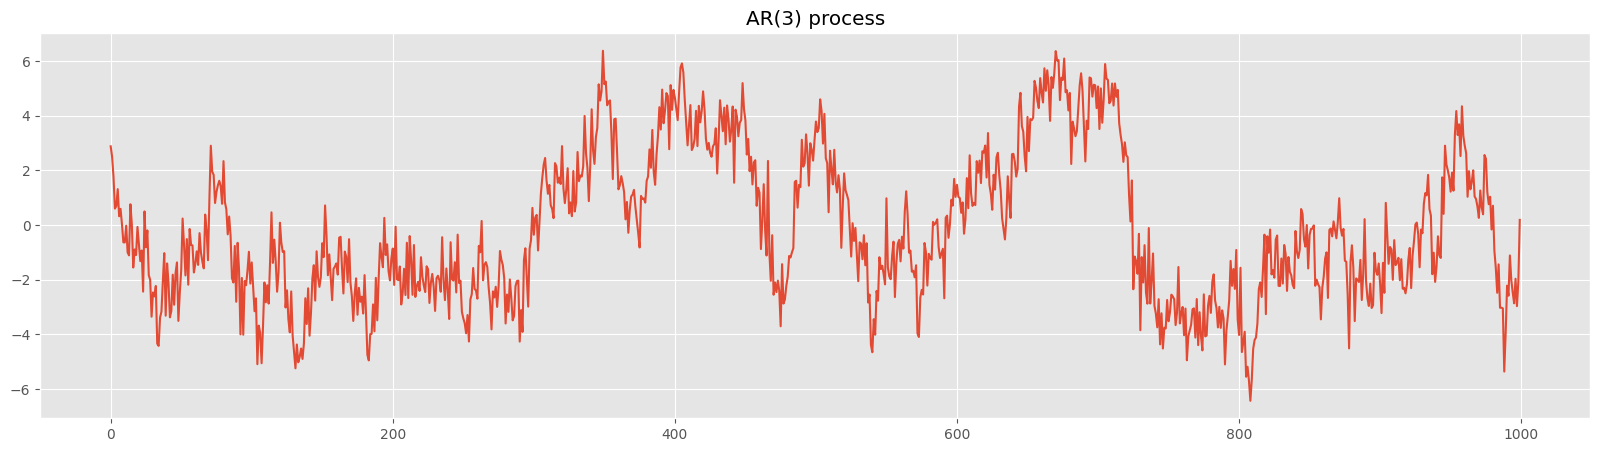

In [36]:
ma_process = tsa.ArmaProcess(ar=[1, -0.5, -0.25, -0.2])
sample = pd.Series(ma_process.generate_sample(nsample=1000, burnin = 10000))
sample.plot()
plt.title('AR(3) process');

In [37]:
sample

0      2.881629
1      2.502491
2      1.768761
3      0.603709
4      0.694305
         ...   
995   -2.862199
996   -1.963879
997   -2.965837
998   -2.057267
999    0.189451
Length: 1000, dtype: float64

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

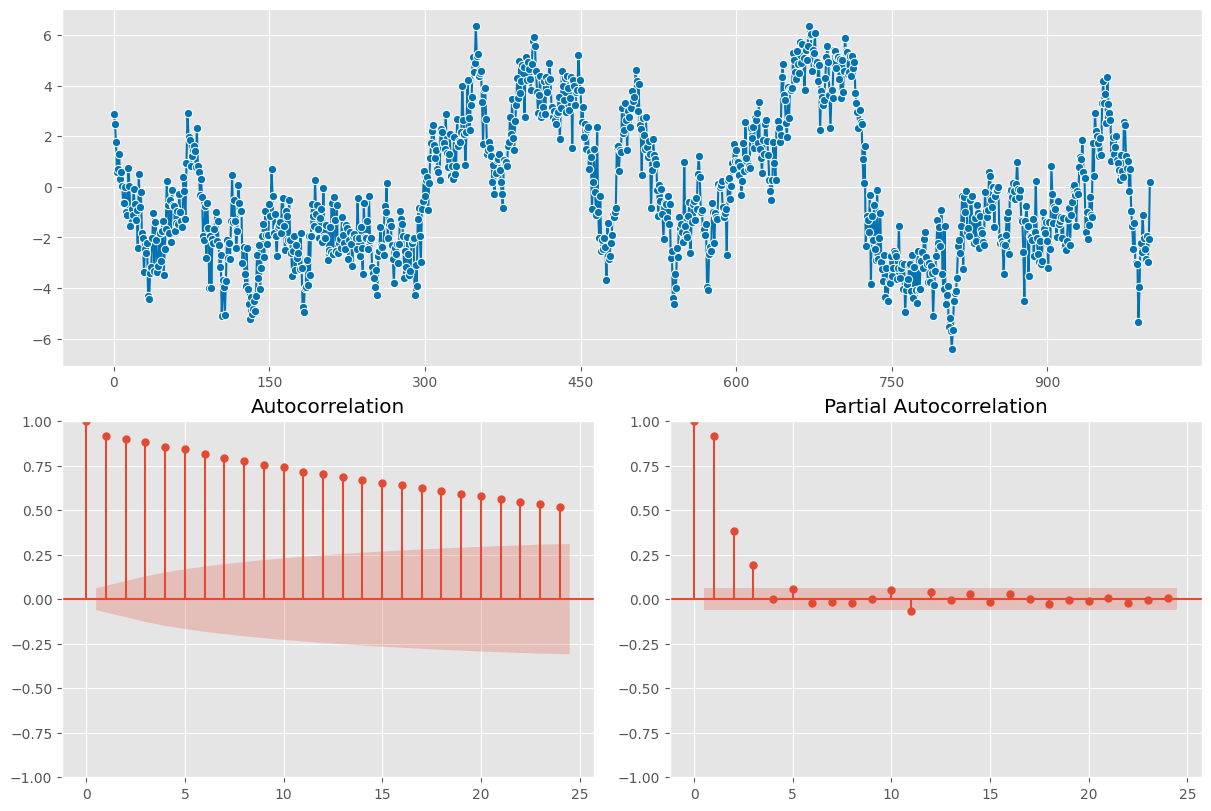

In [38]:
plot_correlations(sample)

In [39]:
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

test_size = 200
train, test = temporal_train_test_split(sample, test_size = test_size)

<Axes: >

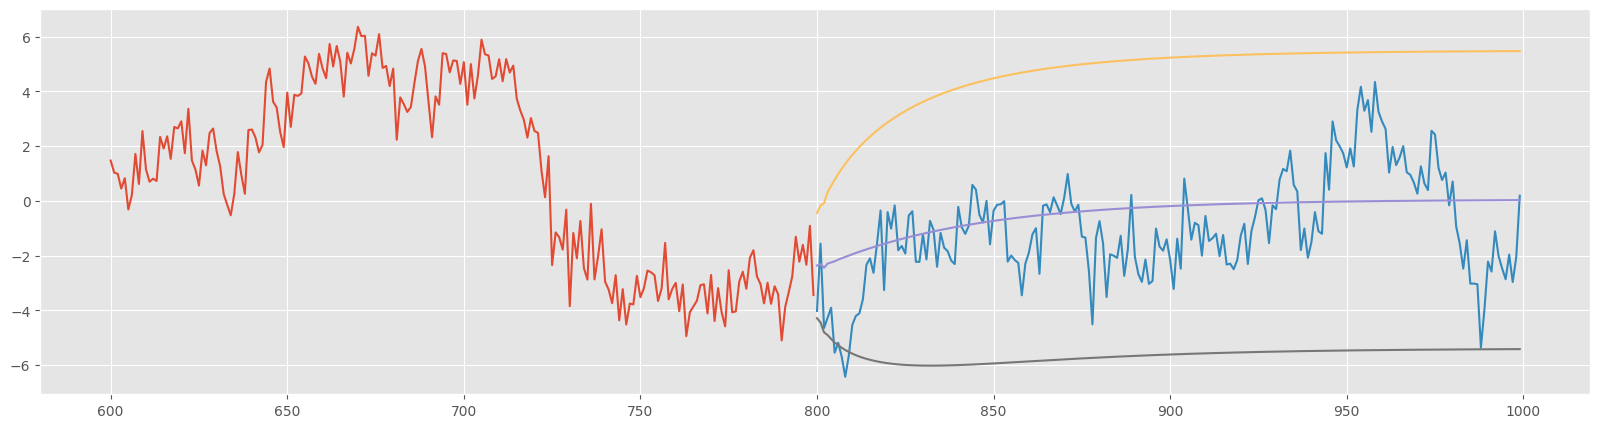

In [41]:
forecaster = ARIMA(order = (3,0,0))

forecaster.fit(train)

forecast = forecaster.predict(list(range(1, test_size+1)))
variance = forecaster.predict_interval(list(range(1, test_size+1)), coverage = 0.95)

train.tail(test_size).plot()
test.plot()
forecast.plot()
variance[0][0.95]['lower'].plot()
variance[0][0.95]['upper'].plot()

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

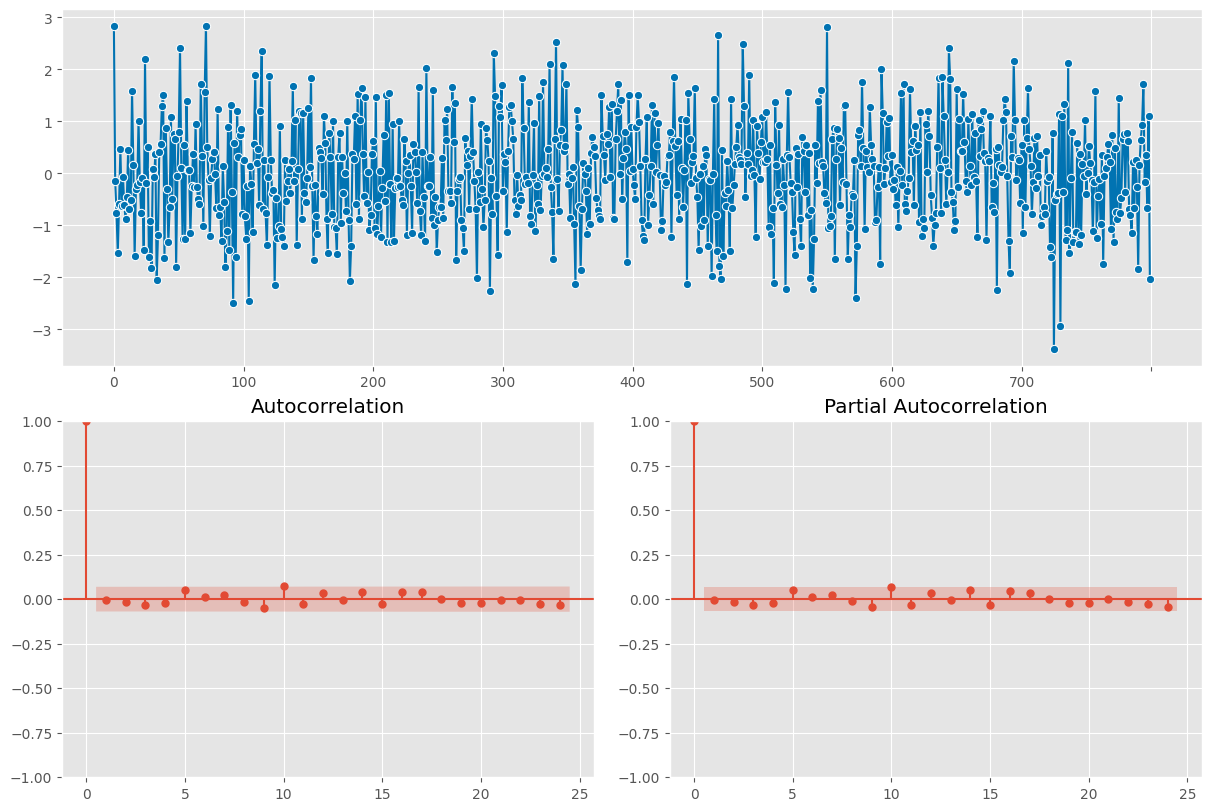

In [42]:
resid = forecaster.predict_residuals()

plot_correlations(resid)

In [43]:
forecaster.predict(list(range(1, 1000+1)))

800    -2.362816
801    -2.308581
802    -2.444688
803    -2.292042
804    -2.247621
          ...   
1795    0.052943
1796    0.052943
1797    0.052943
1798    0.052943
1799    0.052943
Length: 1000, dtype: float64

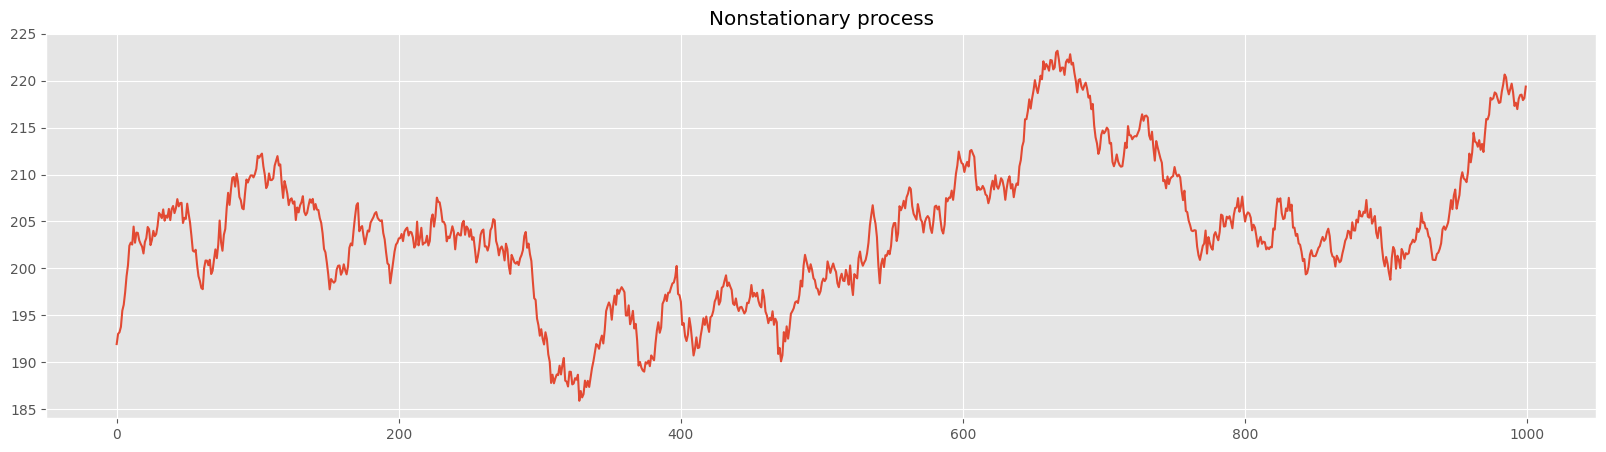

In [44]:
nonstationary_process = tsa.ArmaProcess(ar=[1, -1])
sample = pd.Series(nonstationary_process.generate_sample(nsample=1000, burnin = 10000))
sample.plot()
plt.title('Nonstationary process');


In [45]:
nonstationary_process.isstationary

False

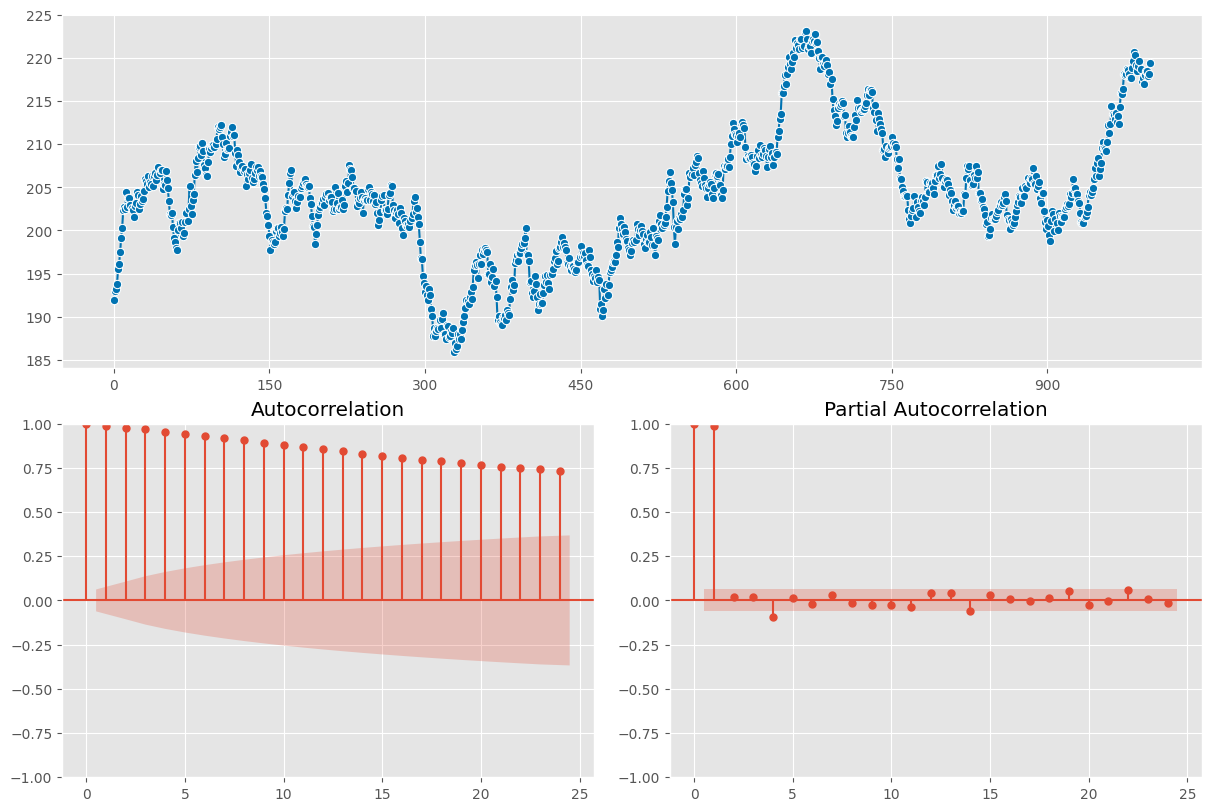

In [46]:
plot_correlations(sample);

### Примеры нестационарных рядов

In [61]:
beta_0 = 1
beta_1 = 0.5
sigma_sq = 16
n_steps = 1000

# Ряд с детерминированным трендом
y_det = [beta_0 + beta_1 * t + np.random.normal(scale=sigma_sq) for t in range(n_steps)]

# Ряд со стохастическим трендом
y_stoch = [0]
[y_stoch.append(beta_0 + y_stoch[-1] + np.random.normal(scale=sigma_sq)) for t in range(n_steps)]

y_det = pd.Series(y_det)
y_stoch = pd.Series(y_stoch)

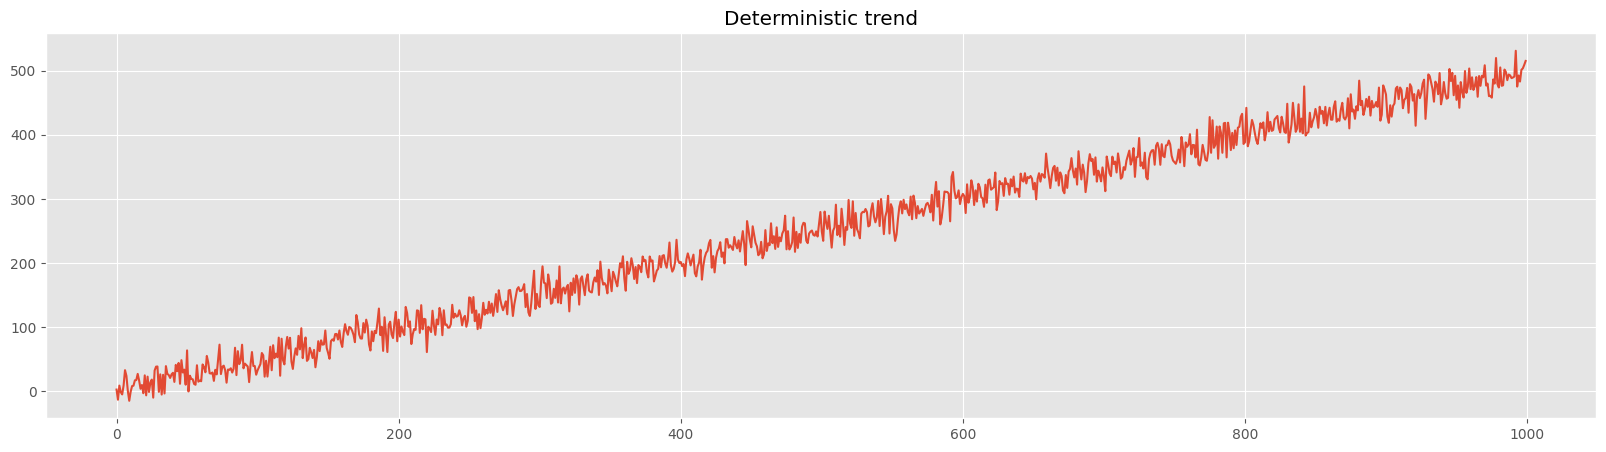

In [62]:
y_det.plot()
plt.title("Deterministic trend");

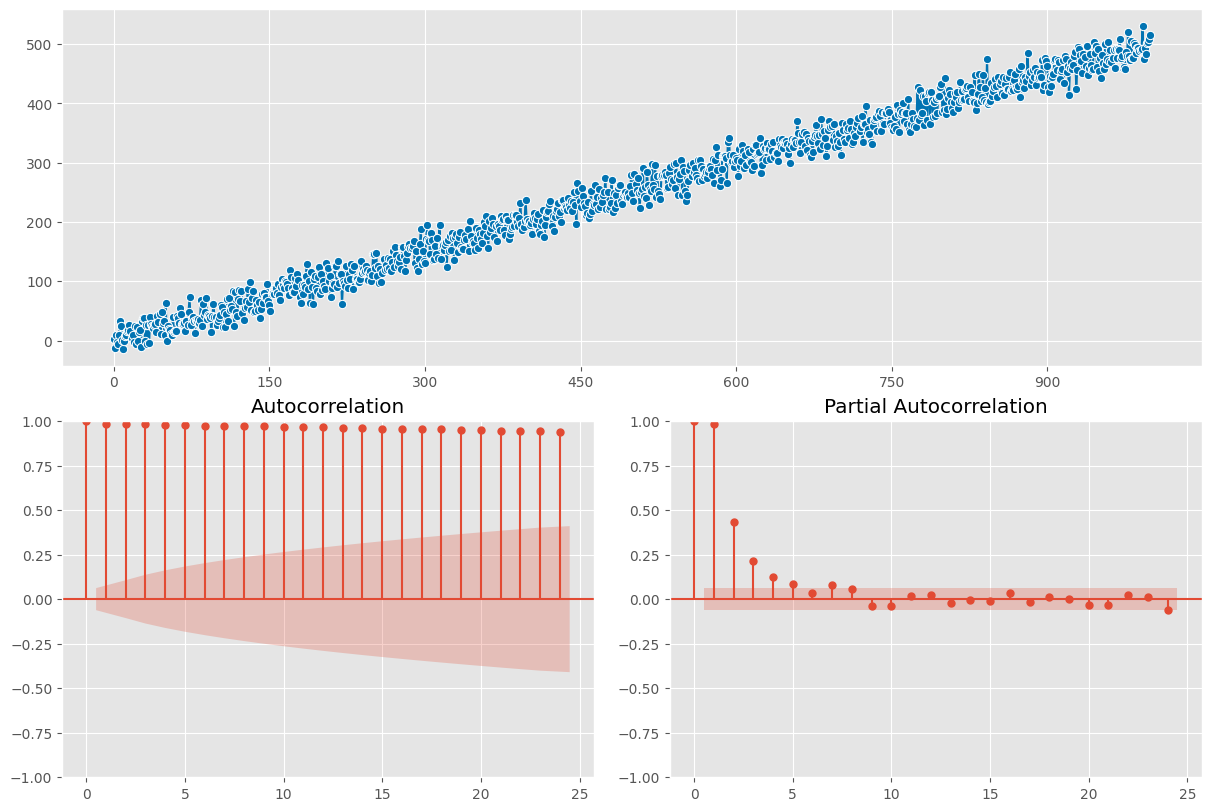

In [63]:
plot_correlations(y_det);

<Axes: >

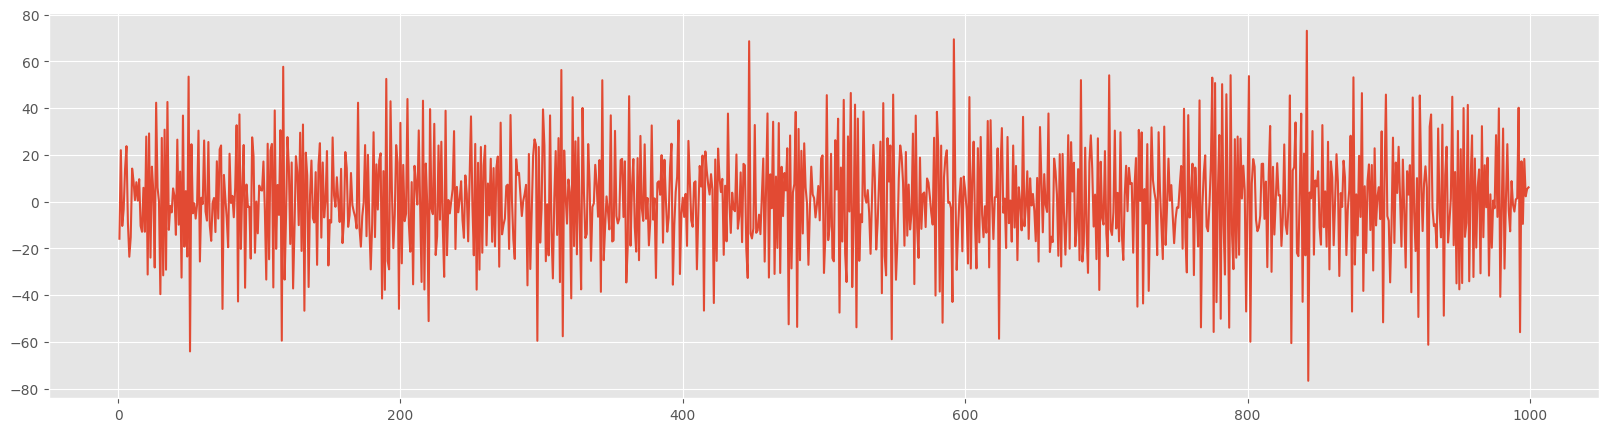

In [64]:
y_det.diff().dropna().plot()

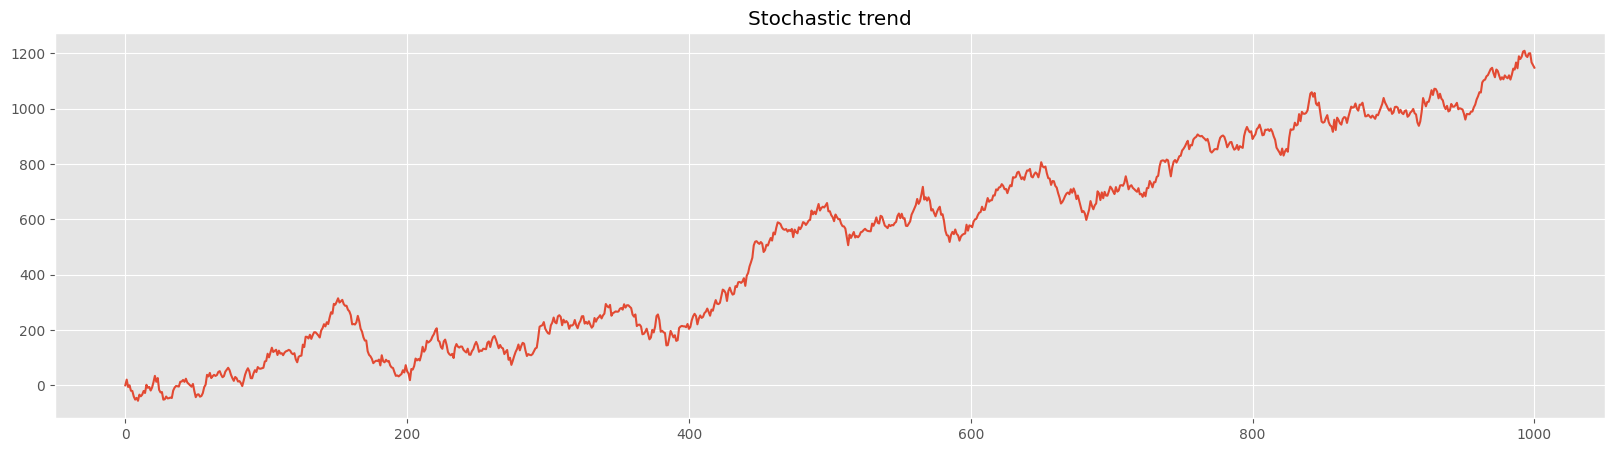

In [65]:
# Ряд со стохастическим трендом
y_stoch = [0]
[y_stoch.append(beta_0 + y_stoch[-1] + np.random.normal(scale=sigma_sq)) for t in range(n_steps)]

y_stoch = pd.Series(y_stoch)
y_stoch.plot()
plt.title("Stochastic trend");

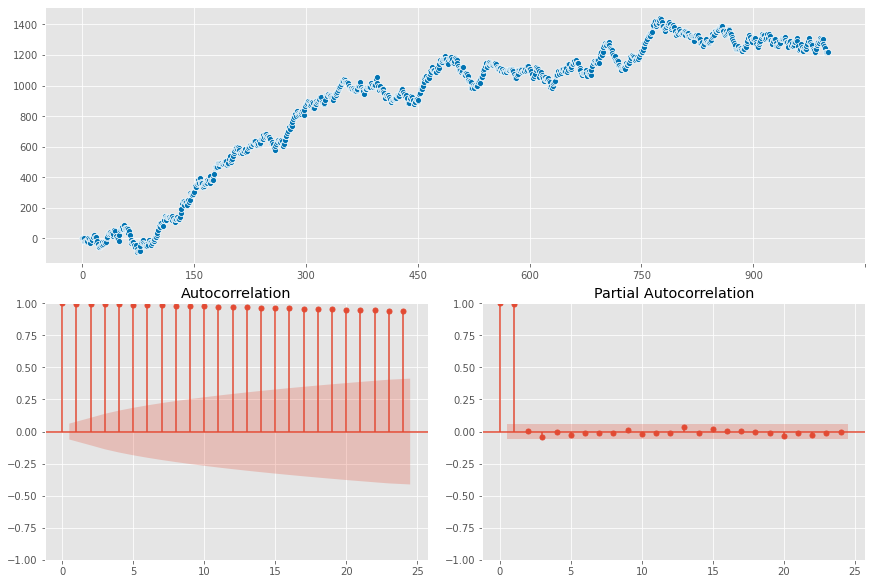

In [39]:
plot_correlations(y_stoch);


<AxesSubplot: >

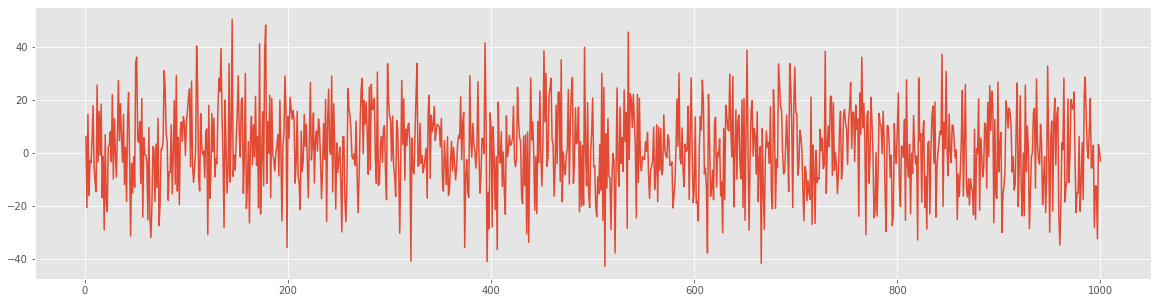

In [41]:
y_stoch.diff().dropna().plot()

Теперь посмотрим на какие-нибудь нестационарные процессы и попытаемся оценить на них ARIMA-модель.

In [66]:
import statsmodels.api as sm
from sktime.forecasting.arima import ARIMA
from sktime.forecasting.model_selection import temporal_train_test_split

test_size = 20

data = sm.datasets.macrodata.load_pandas().data

realgdp = data['realgdp']

train, test = temporal_train_test_split(realgdp, test_size = test_size)

Возьмём какой-нибудь нестационарный ряд.

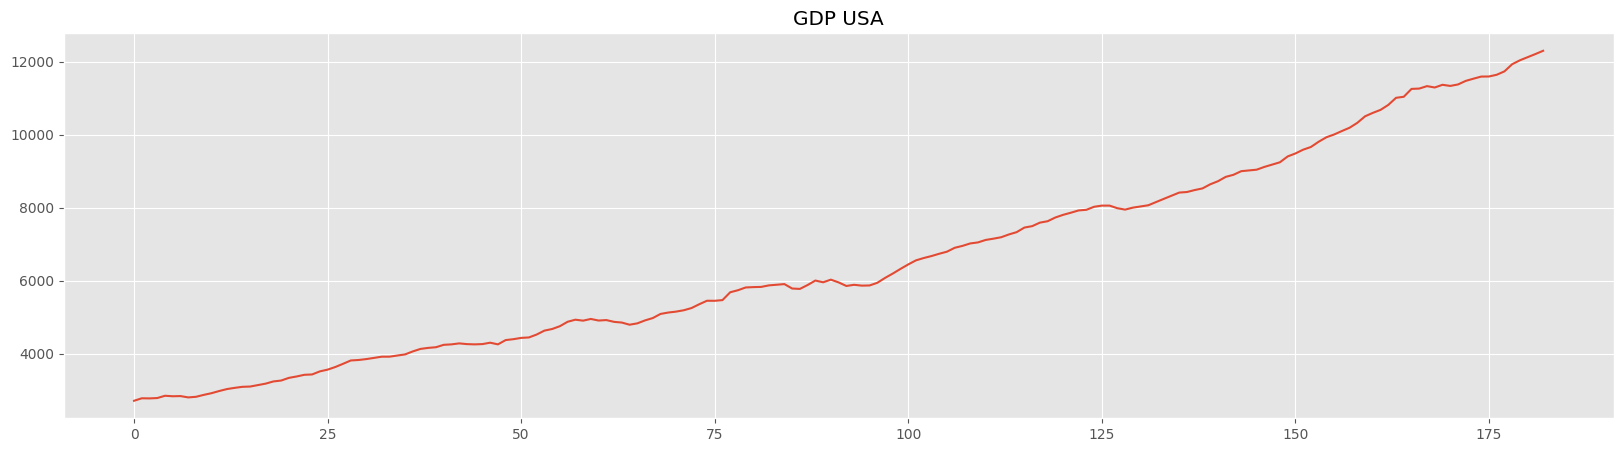

In [67]:
train.plot();
plt.title("GDP USA");

In [68]:
from statsmodels.tsa.stattools import kpss

# Гипотеза о стационарности отвергается
kpss(train)

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_48487/2632653145.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(train)


(1.8785823835768838,
 0.01,
 9,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

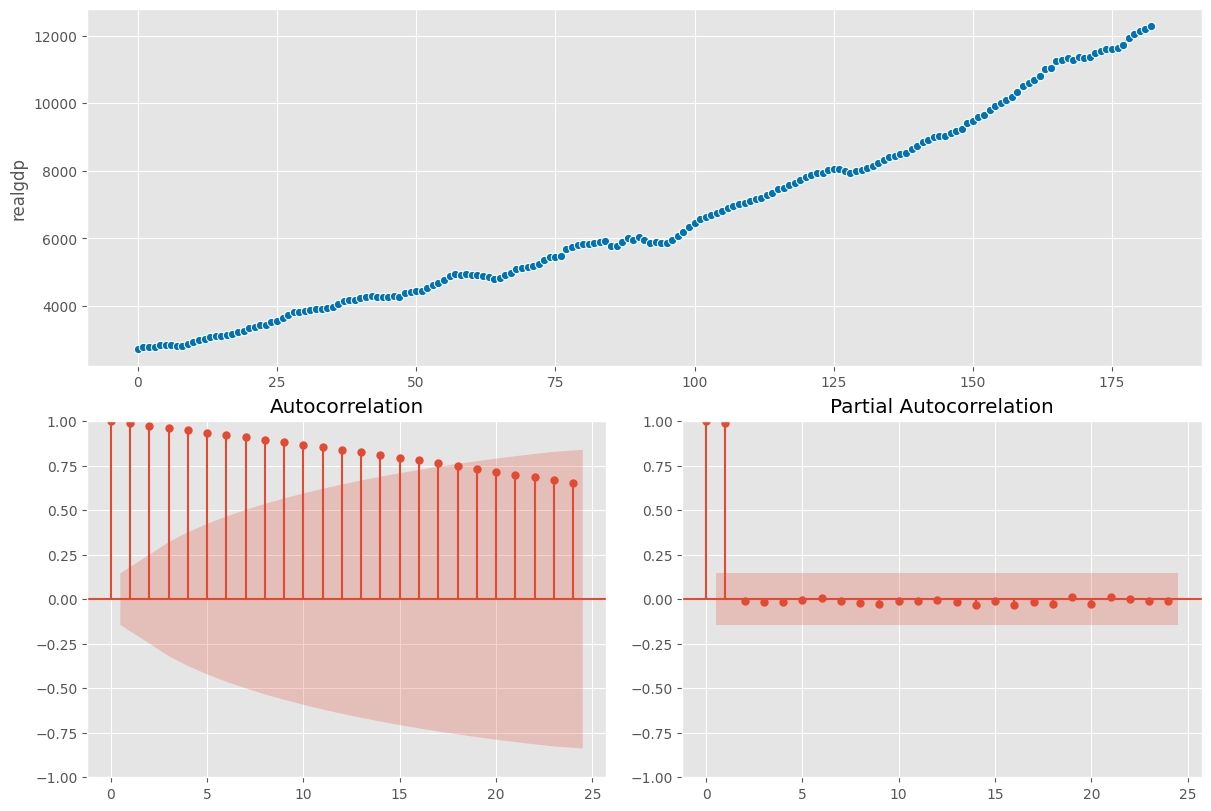

In [69]:
plot_correlations(train);

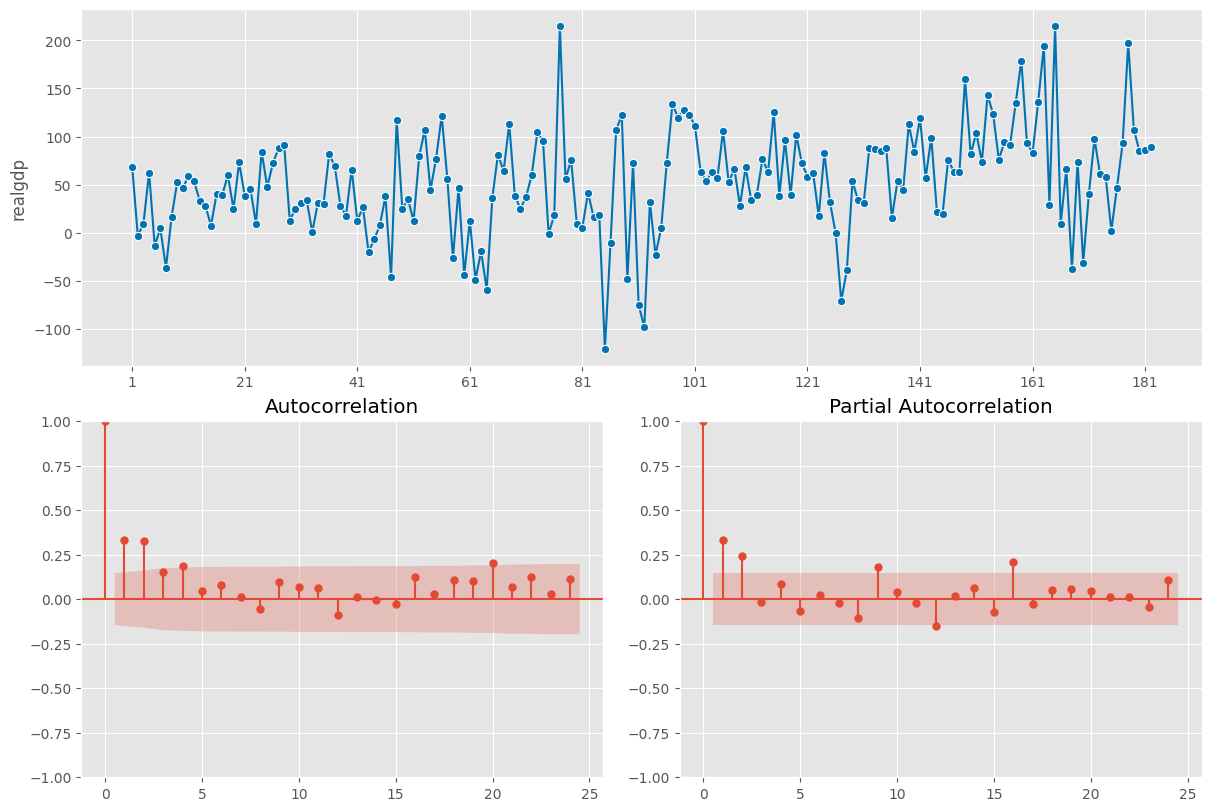

In [70]:
plot_correlations(train.diff().dropna());

In [71]:
# Гипотеза отвергается на 5-процентном уровне значимости. 
kpss(train.diff().dropna())

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_48487/3226727904.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(train.diff().dropna())


(0.8553755732183153,
 0.01,
 6,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

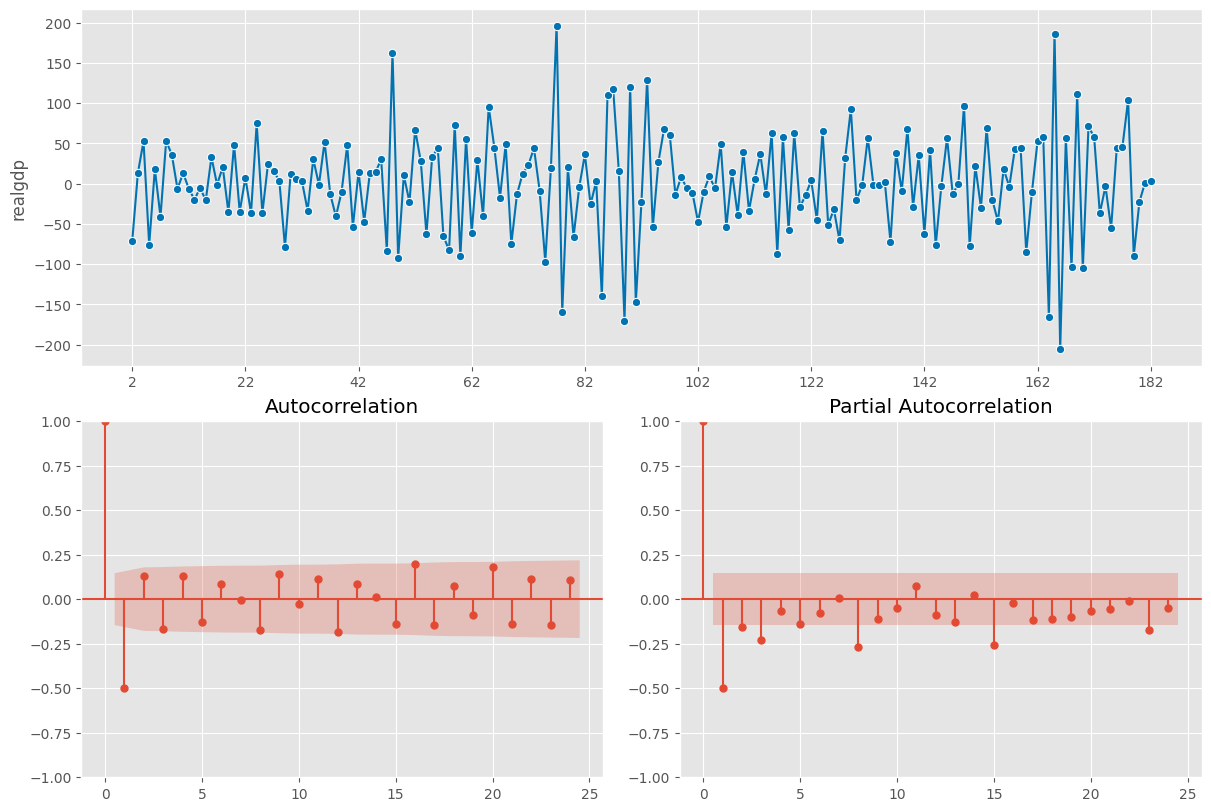

In [72]:
plot_correlations(train.diff().diff().dropna());

In [73]:
# Гипотеза не отвергается на 5-процентном уровне значимости. 
kpss(train.diff().diff().dropna())

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_48487/3550102418.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(train.diff().diff().dropna())


(0.18529319602507982,
 0.1,
 55,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Ряд ВВП -- I(2)

In [74]:
from sktime.forecasting.base import ForecastingHorizon

# creating plot for forecast
# with lablels and title as params
def plot (pred, real):
    plt.plot(pred, label='Forecast')
    plt.plot(real, label='Real')
    plt.legend()
    plt.title('Forecast vs Real')
    plt.show()

In [75]:
test_size

20

In [76]:
max_p = 3
max_q = 1

orders = []

for p in range(max_p+1):
    for q in range(max_q+1):
        orders.append((p, 2, q))
        
fh = ForecastingHorizon(list(range(1, test_size+1)))


In [77]:
orders

[(0, 2, 0),
 (0, 2, 1),
 (1, 2, 0),
 (1, 2, 1),
 (2, 2, 0),
 (2, 2, 1),
 (3, 2, 0),
 (3, 2, 1)]

In [78]:
from sktime.forecasting.arima import AutoARIMA, ARIMA
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV


cv = SlidingWindowSplitter(
    start_with_window=True,
    window_length=60,
    fh=fh,
    step_length=10
)

forecaster = ARIMA()
param_grid = {"order" : orders}

gscv = ForecastingGridSearchCV(
    forecaster=forecaster,
    param_grid=param_grid,
    cv=cv)

gscv.fit(train)
# pred = gscv.predict(fh)

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/sktime/forecasting/model_selection/_tune.py:198: UserWarning: in ForecastingGridSearchCV, n_jobs and pre_dispatch parameters are deprecated and will be removed in 0.26.0. Please use n_jobs and pre_dispatch directly in the backend_params argument instead.
  warn(
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No s

ForecastingGridSearchCV(cv=SlidingWindowSplitter(fh=ForecastingHorizon([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], dtype='int64', is_relative=True),
                                                 step_length=10,
                                                 window_length=60),
                        forecaster=ARIMA(),
                        param_grid={'order': [(0, 2, 0), (0, 2, 1), (1, 2, 0),
                                              (1, 2, 1), (2, 2, 0), (2, 2, 1),
                                              (3, 2, 0), (3, 2, 1)]})

In [79]:
gscv.best_forecaster_.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  183
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -961.558
Date:                Tue, 19 Mar 2024   AIC                           1933.115
Time:                        13:01:07   BIC                           1949.108
Sample:                             0   HQIC                          1939.599
                                - 183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1941      0.068      2.850      0.004       0.061       0.327
ar.L1          0.2084      0.074      2.828      0.005       0.064       0.353
ar.L2          0.2020      0.064      3.143      0.002       0.076       0.328
ma.L1         -0.9996      0.807     -1.238      0.216      -2.582       0.583
sigma2      2350.3123   1846.855      1.273      0.203   -1269.457    5970.081
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                13.33
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                             0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

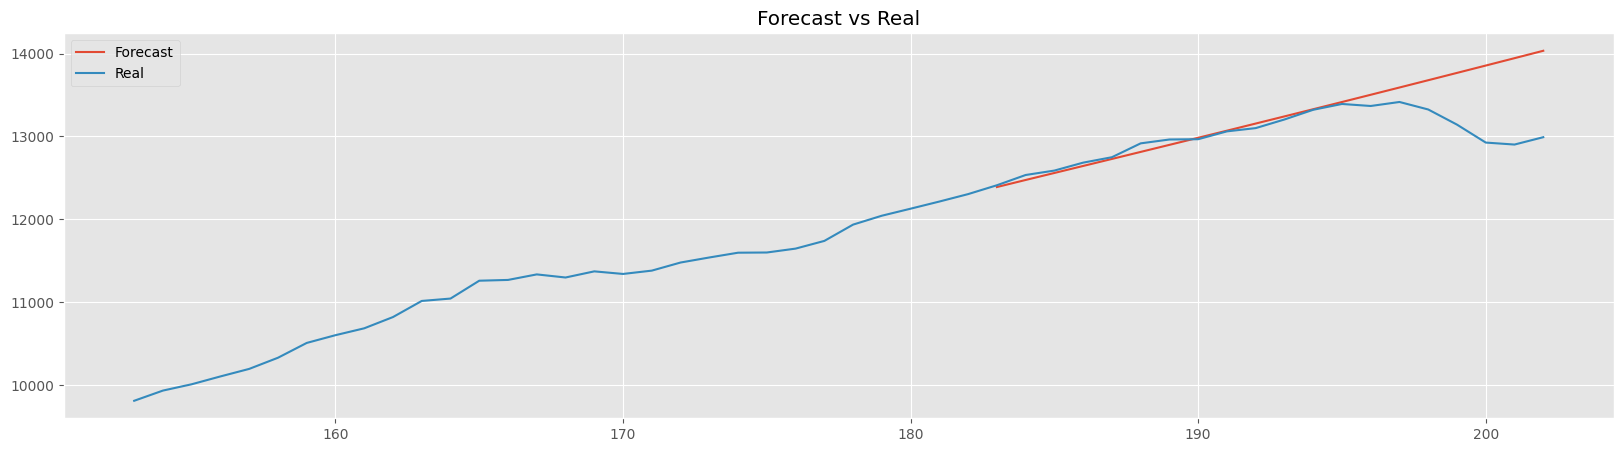

In [80]:
pred = gscv.predict(fh)

plot(pred, realgdp.tail(50))

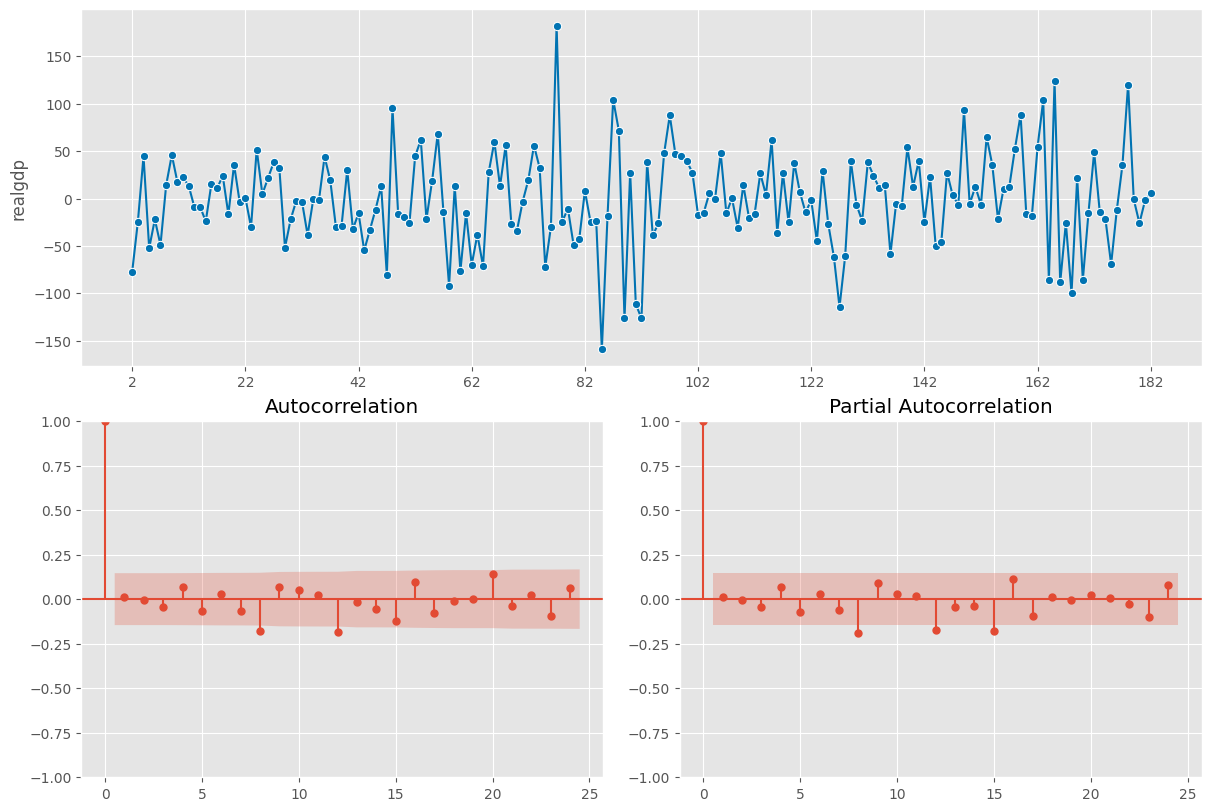

In [81]:
plot_correlations(gscv.predict_residuals().dropna());

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py

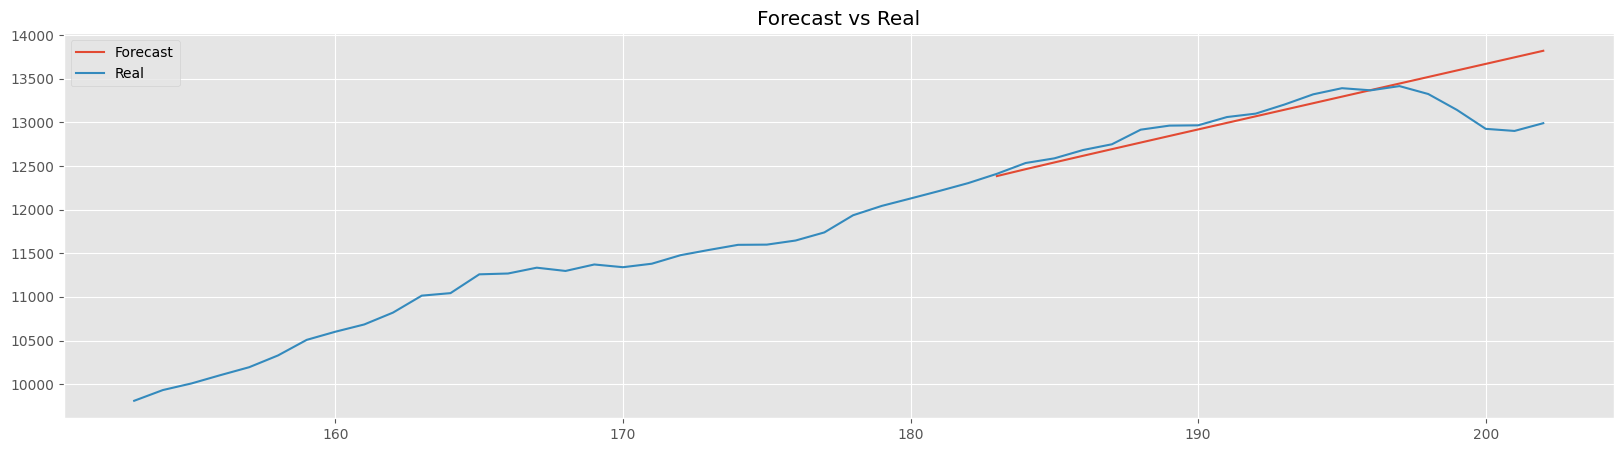

In [82]:
auto_model = AutoARIMA(start_p=0, start_q=0).fit(train)
auto_pred = auto_model.predict(fh)

plot(auto_pred, realgdp.tail(50))

In [83]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  183
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -963.570
Date:                Tue, 19 Mar 2024   AIC                           1935.141
Time:                        13:01:18   BIC                           1947.935
Sample:                             0   HQIC                          1940.328
                                - 183                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2162      0.075      2.897      0.004       0.070       0.362
ar.L2          0.2095      0.063      3.331      0.001       0.086       0.333
ma.L1         -0.9704      0.021    -47.259      0.000      -1.011      -0.930
sigma2      2434.3431    202.668     12.011      0.000    2037.121    2831.565
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                11.46
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.10
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [85]:
brent = pd.read_excel('data/sem_7/brent.xlsx')
brent = brent.set_index('Date')
brent.index = pd.to_datetime(brent.index, format = "%d.%m.%Y")
brent.index = brent.index.to_period(freq="W-MON")
brent = brent.interpolate()

<Axes: xlabel='Date'>

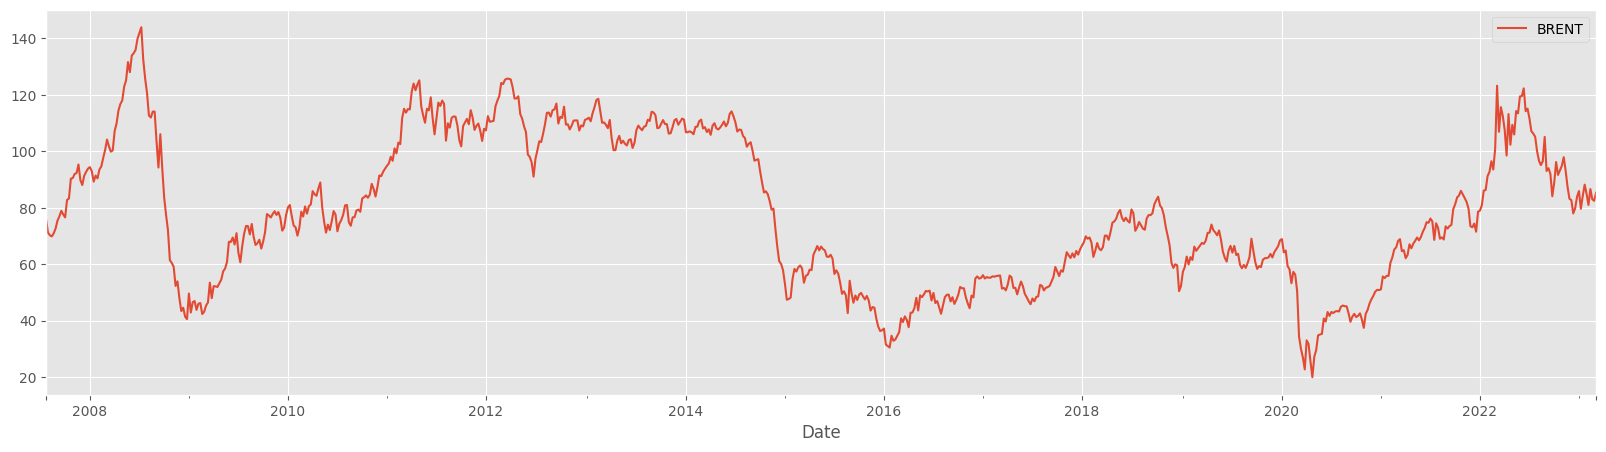

In [86]:
brent.plot()

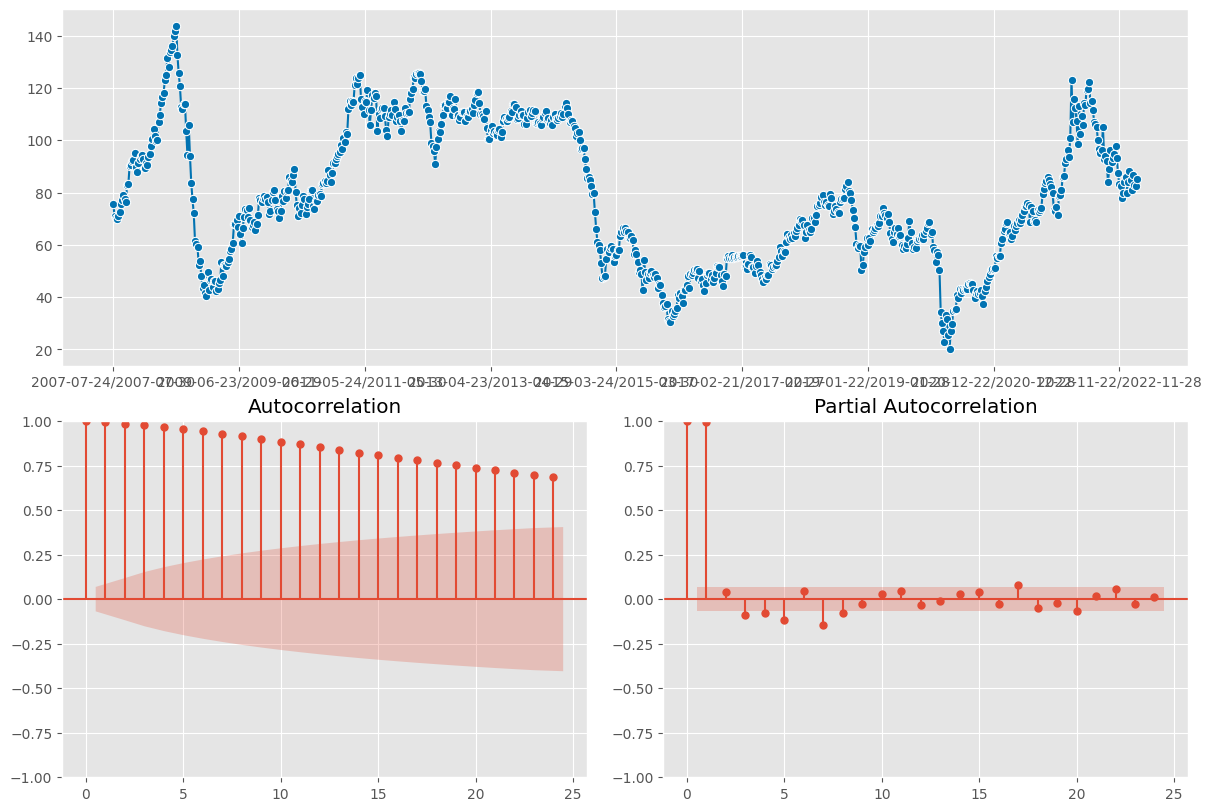

In [87]:
plot_correlations(brent);

In [88]:
kpss(brent)

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_48487/1043598678.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(brent)


(0.9552511578627328,
 0.01,
 18,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

(<Figure size 1200x800 with 3 Axes>,
 array([<Axes: >, <Axes: title={'center': 'Autocorrelation'}>,
        <Axes: title={'center': 'Partial Autocorrelation'}>], dtype=object))

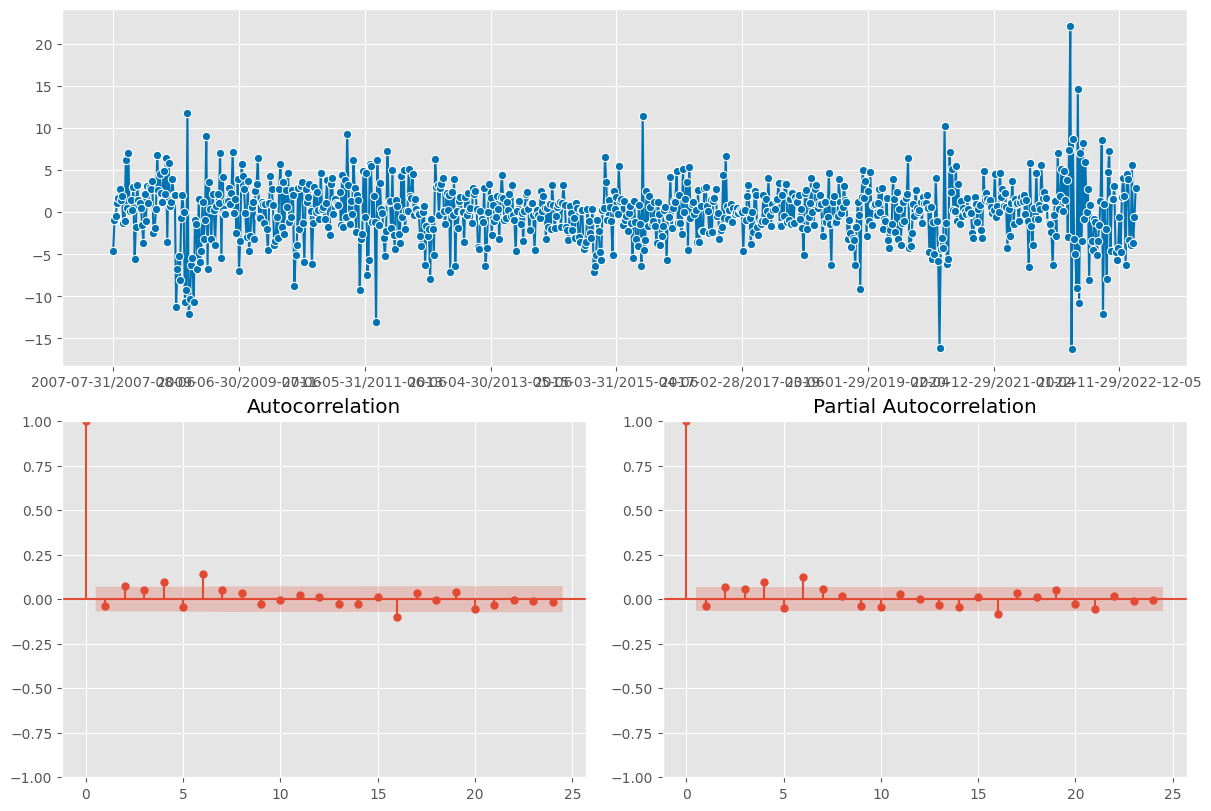

In [89]:
plot_correlations(brent.diff().dropna())

In [90]:
kpss(brent.diff().dropna())

/var/folders/cp/4bl3kvm10tl3r81sxqkgg1q00000gn/T/ipykernel_48487/459427387.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(brent.diff().dropna())


(0.051494871250905766,
 0.1,
 10,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [91]:
train, test = temporal_train_test_split(brent, test_size=0.1)

In [92]:
auto_model = AutoARIMA(start_p=0, start_q=0).fit(train)

fh = ForecastingHorizon(list(range(1, len(test)+1)))
auto_pred = auto_model.predict(fh=fh)

/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/mszekhov/Desktop/current_projects/hse_ts_course/venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py

In [93]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  733
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1891.222
Date:                Tue, 19 Mar 2024   AIC                           3788.444
Time:                        13:02:10   BIC                           3802.231
Sample:                    07-30-2007   HQIC                          3793.762
                         - 08-09-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8631      0.068     12.773      0.000       0.731       0.996
ma.L1         -0.7952      0.083     -9.604      0.000      -0.957      -0.633
sigma2        10.2712      0.374     27.441      0.000       9.538      11.005
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               159.79
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.52   Skew:                            -0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [94]:
brent.index = brent.index.to_timestamp()
auto_pred.index = auto_pred.index.to_timestamp()


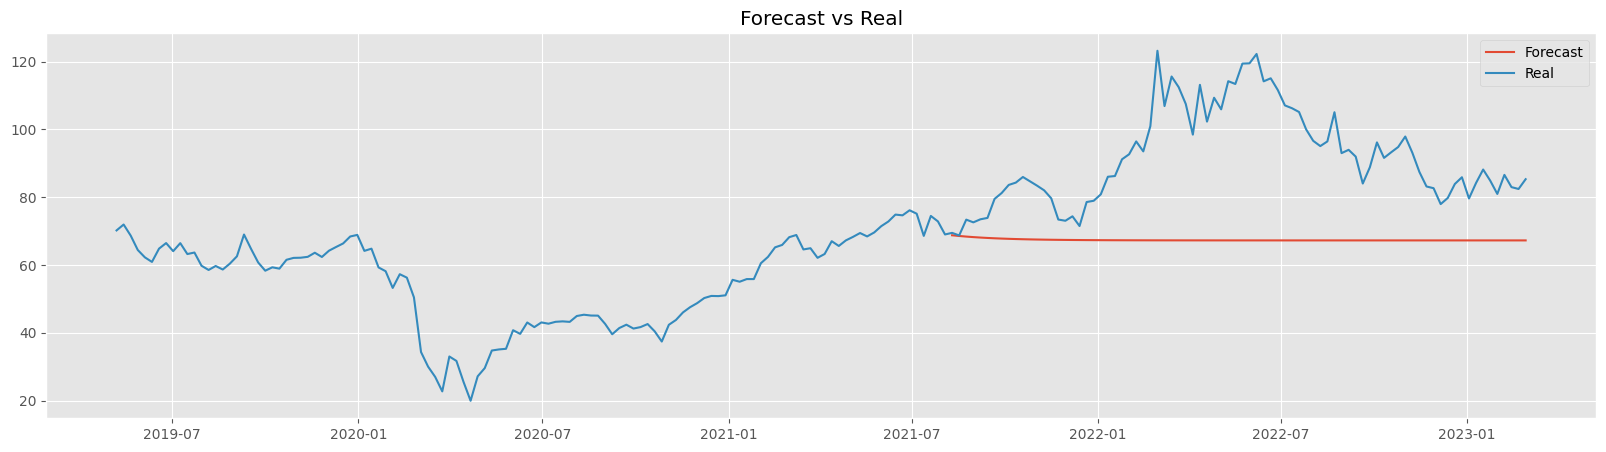

In [95]:
plot(auto_pred, brent.tail(200))
